# **Compare Performance of Investment Strategy Based on Neural Network Models including MLP, RNN, CNN to Predict S&P 500 Index Level Using Technical Indicators from Daily Time Series**

We are using this code to evaluate the 3 NN ie LSTM,MLP and CNN. We replaced RNN with LTSM because LSTM are a specialized RNN. They handle vanishing gradient problem and standard RNN struggle with long sequences. We have combined all four of them

In [ ]:
!pip install pyts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.1 MB/s eta 0:00:00


In [ ]:
!pip install pandas-ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=90234ac979fedaa1a778758a29ff769bd88471f49be906f965dd41cae96ef662
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas-ta


## **1. Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import tensorflow as tf
import pandas_ta as ta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Conv1D, Conv2D, MaxPooling2D, InputLayer, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import Xception, InceptionV3
from pyts.image import GramianAngularField

## **2. Importing data and feature engineering**

### **Vanilla and Technical indicators**

**Trend and Momentum Indicators**
- Open, Close, High, Low of prices
- Rolling returns
- EMA (Exponential Moving Average) of prices
- RSI (Relative Strength Index)
- MACD (Moving Average Convergence Divergence)
- ADX (Average Directional Index)

**Volume Indicators**
- Daily Trading Volume
- OBV (On-Balance Volume)
- A/D Line (Accumulation/Distribution Line)

**Volatility Indicators**
- Volatility of returns
- Volatility of prices
- BB (Bollinger Bands)
- ATR (Average True Range)

### **Inputs and Output**

**Inputs**: The various researched technical indicators and some vanilla data.

In [ ]:
target = "^GSPC"
#target = "AAPL"
#raw_df = yf.download(target, start="2014-01-01", end="2024-12-31", progress=False)
raw_df = yf.download(target, start="2014-01-01", end="2025-02-28", progress=False)
data_df = raw_df.copy()
data_df.columns = data_df.columns.droplevel(1) # since we only have one ticker
data_df.columns.name = None
data_df['Ret'] = data_df['Close'].pct_change()
data_df.reset_index(inplace=True)

### Trend and Momentum Indicators
# Rolling Return
data_df["Roll25"] = data_df['Ret'].rolling(25).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
data_df["Roll60"] = data_df['Ret'].rolling(60).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
data_df["Roll90"] = data_df['Ret'].rolling(90).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
data_df["Roll120"] = data_df['Ret'].rolling(120).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
data_df["Roll240"] = data_df['Ret'].rolling(240).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
# Simple Moving Average of Price
data_df["SMA10"] = ta.sma(data_df['Close'],10)
data_df["SMA50"] = ta.sma(data_df['Close'],50)
data_df["SMA200"] = ta.sma(data_df['Close'],200)
data_df['SMA_Cross'] = np.where(data_df['SMA10'] > data_df['SMA50'], 1, 0)
data_df['SMA_Cross'] = data_df['SMA_Cross'].diff()
data_df['SMA_Cross_50_200'] = np.where(data_df['SMA50'] > data_df['SMA200'], 1, 0)
data_df['SMA_Cross_50_200'] = data_df['SMA_Cross_50_200'].diff()
data_df['SMA_Cross_1_50'] = np.where(data_df['Close'] > data_df['SMA50'], 1, 0)
data_df['SMA_Cross_1_50'] = data_df['SMA_Cross_1_50'].diff()
# Exponential Moving Average of Price
data_df["EMA10"] = ta.ema(data_df['Close'],10)
data_df["EMA50"] = ta.ema(data_df['Close'],50)
data_df["EMA200"] = ta.ema(data_df['Close'],200)
data_df['EMA_Cross'] = np.where(data_df['EMA10'] > data_df['EMA50'], 1, 0)
data_df['EMA_Cross'] = data_df['EMA_Cross'].diff()
data_df['EMA_Cross_50_200'] = np.where(data_df['EMA50'] > data_df['EMA200'], 1, 0)
data_df['EMA_Cross_50_200'] = data_df['EMA_Cross_50_200'].diff()
data_df['EMA_Cross_1_50'] = np.where(data_df['Close'] > data_df['EMA50'], 1, 0)
data_df['EMA_Cross_1_50'] = data_df['EMA_Cross_1_50'].diff()
# RSI
data_df['RSI'] = ta.rsi(data_df['Close'], length=14)
data_df['RSI_Cross'] = np.select(
    [(data_df['RSI'] < 30) & (data_df['RSI'].shift(1) >= 30),
    (data_df['RSI'] > 70) & (data_df['RSI'].shift(1) <= 70),],
    [1, -1], default=0)
data_df['RSI_Cross_back'] = np.select(
    [(data_df['RSI'].shift(1) < 30) & (data_df['RSI'] >= 30),
    (data_df['RSI'].shift(1) > 70) & (data_df['RSI'] <= 70)],
    [1, -1], default=0)
# MACD
macd = ta.macd(data_df['Close'],12,26,9)
data_df['MACD'] = macd['MACD_12_26_9']
data_df['MACD_Signal'] = macd['MACDs_12_26_9']
data_df['MACD_Hist'] = macd['MACDh_12_26_9']
data_df['MACD_Signal_Cross'] = np.where(data_df['MACD'] > data_df['MACD_Signal'], 1, 0)
data_df['MACD_Signal_Cross'] = data_df['MACD_Signal_Cross'].diff()
data_df['MACD_Zero_Cross'] = np.where(data_df['MACD'] > 0, 1, 0)
data_df['MACD_Zero_Cross'] = data_df['MACD_Zero_Cross'].diff()
# ADX
adx = ta.adx(data_df['High'], data_df['Low'], data_df['Close'], length=14)
data_df['ADX'] = adx['ADX_14']
data_df['ADX_SMA_Cross'] = np.select(
    [(data_df['ADX'] > 20) & (data_df['SMA_Cross'] == 1),
    (data_df['ADX'] > 20) & (data_df['SMA_Cross'] == -1)],
    [1, -1], default=0)
data_df['ADX_EMA_Cross'] = np.select(
    [(data_df['ADX'] > 20) & (data_df['EMA_Cross'] == 1),
    (data_df['ADX'] > 20) & (data_df['EMA_Cross'] == -1)],
    [1, -1], default=0)
data_df['ADX_RSI_Cross'] = np.select(
    [(data_df['ADX'] > 20) & (data_df['RSI_Cross'] == 1),
    (data_df['ADX'] > 20) & (data_df['RSI_Cross'] == -1)],
    [1, -1], default=0)
data_df['ADX_RSI_Cross_back'] = np.select(
    [(data_df['ADX'] > 20) & (data_df['RSI_Cross_back'] == 1),
    (data_df['ADX'] > 20) & (data_df['RSI_Cross_back'] == -1)],
    [1, -1], default=0)
data_df['ADX_MACD_Signal_Cross'] = np.select(
    [(data_df['ADX'] > 20) & (data_df['MACD_Signal_Cross'] == 1),
    (data_df['ADX'] > 20) & (data_df['MACD_Signal_Cross'] == -1)],
    [1, -1], default=0)
data_df['ADX_MACD_Zero_Cross'] = np.select(
    [(data_df['ADX'] > 20) & (data_df['MACD_Zero_Cross'] == 1),
    (data_df['ADX'] > 20) & (data_df['MACD_Zero_Cross'] == -1)],
    [1, -1], default=0)

### Volume Indicators
# OBV
data_df['OBV'] = ta.obv(data_df['Close'], data_df['Volume'])
data_df['OBV_Slope'] = data_df['OBV'].diff(5)
# A/D Line
data_df['A/D Line'] = ta.ad(data_df['High'], data_df['Low'], data_df['Close'], data_df['Volume'])
data_df['A/D Line_Slope'] = data_df['A/D Line'].diff(5)

### Volatility Indicators
# Standard Deviation of return
data_df["Vol10_r"] = data_df['Ret'].rolling(10).std()
# Standard Deviation of price
data_df["Vol10_p"] = data_df['Close'].rolling(10).std()
# Bollinger Bands
bb = ta.bbands(data_df['Close'], length=20, std=2)
data_df['BB_Upper'] = bb['BBU_20_2.0']
data_df['BB_Middle'] = bb['BBM_20_2.0']
data_df['BB_Lower'] = bb['BBL_20_2.0']
# ATR
data_df['ATR'] = ta.atr(data_df['High'], data_df['Low'], data_df['Close'], length=14)

In [ ]:
#data_df.loc[(data_df['Date'] >= '2024-01-01') & (data_df['Date'] <= '2024-03-01'),['Date','RSI','RSI_Buy','RSI_Buy_back']].tail(60)

**Outputs**: The trend for the next 7 days: whether the price will go up or down after 7 days.

In [ ]:
window = 7
data_df["Output"] = data_df['Close'].shift(-window) > data_df['Close']
data_df["Output"] = data_df["Output"].astype(int)

**Finalize**: Drop missing data

In [ ]:
data_df = data_df.dropna()
print(data_df.shape)

(2566, 50)


In [ ]:
print(data_df.columns)

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Ret', 'Roll25',
       'Roll60', 'Roll90', 'Roll120', 'Roll240', 'SMA10', 'SMA50', 'SMA200',
       'SMA_Cross', 'SMA_Cross_50_200', 'SMA_Cross_1_50', 'EMA10', 'EMA50',
       'EMA200', 'EMA_Cross', 'EMA_Cross_50_200', 'EMA_Cross_1_50', 'RSI',
       'RSI_Cross', 'RSI_Cross_back', 'MACD', 'MACD_Signal', 'MACD_Hist',
       'MACD_Signal_Cross', 'MACD_Zero_Cross', 'ADX', 'ADX_SMA_Cross',
       'ADX_EMA_Cross', 'ADX_RSI_Cross', 'ADX_RSI_Cross_back',
       'ADX_MACD_Signal_Cross', 'ADX_MACD_Zero_Cross', 'OBV', 'OBV_Slope',
       'A/D Line', 'A/D Line_Slope', 'Vol10_r', 'Vol10_p', 'BB_Upper',
       'BB_Middle', 'BB_Lower', 'ATR', 'Output'],
      dtype='object')


In [ ]:
print(data_df["Output"].value_counts())

Output
1    1573
0     993
Name: count, dtype: int64


The output looks fine without significant imbalance (60:40). After all we are looking at market index, it makes sense to see overall increase due to inflation.

### **Seven Sets of Input Data**

- Set A: Return only
- Set B: Price only
- Set C: Vanilla factors based on return
- Set D: Vanilla factors based on price
- Set E: Technical Factors only
- Set F: Mix of Vanilla and Technical Factors - Set#1 - MACD and ADX
- Set G: Mix of Vanilla and Technical Factors - Set#2 - RSI and ADX
- Set H: Mix of Vanilla and Technical Factors - Set#3 - Momentum only

In [ ]:
Sets = {
    'Set_A': ['Ret'],
    'Set_B': ['Close', 'High', 'Low', 'Open'],
    'Set_C': ['Roll25', 'Roll60', 'Roll90', 'Roll120', 'Roll240', 'Volume', 'Vol10_r'],
    'Set_D': ['Close', 'High', 'Low', 'Open', 'EMA10', 'EMA50', 'EMA200', 'Volume', 'Vol10_p'],
    'Set_E': ['RSI', 'MACD', 'MACD_Signal', 'ADX', 'OBV_Slope', 'A/D Line_Slope', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'ATR'],
    'Set_F': ['Close', 'MACD', 'MACD_Signal', 'OBV_Slope', 'ATR'],
    'Set_G': ['Close', 'RSI', 'ADX', 'OBV_Slope', 'ATR'],
    'Set_H': ['Close', 'MACD', 'MACD_Signal', 'RSI', 'ADX']
}

## **3. Data Preprocessing**

**Splitting Data into Training & Testing Sets for Input and Output**

In [ ]:
train_split = 0.8
train_size = int(train_split * len(data_df))
train_data = data_df.iloc[:train_size]
test_data = data_df.iloc[train_size:]
X_train_set = train_data.drop(columns=['Date','Output'])
X_test_set = test_data.drop(columns=['Date','Output'])
y_train_set = train_data.loc[:,'Output'].values.reshape(-1, 1) #reshape so as to fit MinMaxScaler()
y_test_set = test_data.loc[:,'Output'].values.reshape(-1, 1)
print(X_train_set.shape, y_train_set.shape, X_test_set.shape, y_test_set.shape)

(813, 29) (813, 1) (204, 29) (204, 1)


In [ ]:
test_time = test_data['Date'].values # save date and actual return for portfolio backtesting later
Ret_vector = test_data['Ret'].values
print(test_time.shape, Ret_vector.shape)

(204,) (204,)


The data is split between 80% and 20% for training and testing

**Normalising Data**

Note that the scaler should only fit on training set.

The values are scaled between -1 and 1 by MinMaxScaler which improves NN convergence and reduce bias across features

In [ ]:
scaler_input = MinMaxScaler(feature_range=(-1, 1))
scaler_input.fit(X_train_set)
data_columns = X_train_set.columns
X_train_set_scaled = scaler_input.transform(X_train_set)
X_test_set_scaled = scaler_input.transform(X_test_set)
X_train_set_scaled = pd.DataFrame(X_train_set_scaled, columns=data_columns)
X_test_set_scaled = pd.DataFrame(X_test_set_scaled, columns=data_columns)

#scaler_output = MinMaxScaler(feature_range=(-1, 1))
#scaler_output.fit(y_train_set)
#y_train_set_scaled = scaler_output.transform(y_train_set)
#y_test_set_scaled = scaler_output.transform(y_test_set)
#y_train_set_scaled = pd.DataFrame(y_train_set_scaled, columns=['Output'])
#y_test_set_scaled = pd.DataFrame(y_test_set_scaled, columns=['Output'])
y_train_set = pd.DataFrame(y_train_set, columns=['Output'])
y_test_set = pd.DataFrame(y_test_set, columns=['Output'])

**Simple data for MLP**

In [ ]:
def create_set_data_X(data, sets):
    X = {}
    for set_name, columns in sets.items():
        subset_data = data[columns].values  # Convert to NumPy array
        X[set_name] = np.array(subset_data)
    return X

In [ ]:
X_train = create_set_data_X(X_train_set_scaled, Sets)
X_test = create_set_data_X(X_test_set_scaled, Sets)
y_train = np.array(y_train_set)#_scaled)
y_test = np.array(y_test_set)#_scaled)

In [ ]:
print('y', y_train.shape, y_test.shape)
for set_name, columns in Sets.items():
    print('X', set_name, X_train[set_name].shape, X_test[set_name].shape)

y (813, 1) (204, 1)
X Set_A (813, 1) (204, 1)
X Set_B (813, 4) (204, 4)
X Set_C (813, 7) (204, 7)
X Set_D (813, 9) (204, 9)
X Set_E (813, 10) (204, 10)
X Set_F (813, 5) (204, 5)
X Set_G (813, 5) (204, 5)
X Set_H (813, 7) (204, 7)
X Set_I (813, 5) (204, 5)


**Create Sequences for RNN and CNN**

In [ ]:
def create_sequences_X(data, seq_length, sets):
    sequences = {}
    for set_name, columns in sets.items():
        subset_data = data[columns].values  # Convert to NumPy array
        X = []
        for i in range(len(subset_data) - seq_length + 1):
            X.append(subset_data[i:i + seq_length])
        sequences[set_name] = np.array(X)
    return sequences

def create_sequences_y(data, seq_length):
    subset_data = data['Output'].values  # Convert to NumPy array
    y = []
    for i in range(len(subset_data) - seq_length+1):
        y.append(subset_data[i + seq_length - 1])
    return np.array(y)

In [ ]:
seq_length = 30  # 30-day sequence
X_train_seq = create_sequences_X(X_train_set_scaled, seq_length, Sets)
X_test_seq = create_sequences_X(X_test_set_scaled, seq_length, Sets)
y_train_seq = create_sequences_y(y_train_set, seq_length)
y_test_seq = create_sequences_y(y_test_set, seq_length)

In [ ]:
test_time_seq = test_data['Date'].values[seq_length-1:]
Ret_vector_seq = test_data['Ret'].values[seq_length-1:]
print(test_time_seq.shape, Ret_vector_seq.shape)

(175,) (175,)


In [ ]:
print('y', y_train_seq.shape, y_test_seq.shape)
for set_name, columns in Sets.items():
    print('X', set_name, X_train_seq[set_name].shape, X_test_seq[set_name].shape)

y (784,) (175,)
X Set_A (784, 30, 1) (175, 30, 1)
X Set_B (784, 30, 4) (175, 30, 4)
X Set_C (784, 30, 7) (175, 30, 7)
X Set_D (784, 30, 9) (175, 30, 9)
X Set_E (784, 30, 10) (175, 30, 10)
X Set_F (784, 30, 5) (175, 30, 5)
X Set_G (784, 30, 5) (175, 30, 5)
X Set_H (784, 30, 7) (175, 30, 7)
X Set_I (784, 30, 5) (175, 30, 5)


**Transform Price to GAF for CNN**

In [ ]:
def generate_gaf(data, seq_lenth, sets):
    transformer = GramianAngularField()
    gaf_data = {}
    for set_name, columns in sets.items():
        feature_data_gaf = []
        for i in range(data[set_name].shape[-1]):
            feature_data = data[set_name][:,:,i]
            feature_data_transformed = transformer.fit_transform(feature_data)
            # rescale GAF to the [0,255] scale
            feature_data_rescaled = feature_data_transformed[:-seq_length]
            for j in range(feature_data_rescaled.shape[0]):
                feature_data_rescaled[j] = (feature_data_rescaled[j] - np.min(feature_data_rescaled[j])) / (np.max(feature_data_rescaled[j]) - np.min(feature_data_rescaled[j]))
            feature_data_rescaled = feature_data_rescaled * 255
            feature_data_gaf.append(feature_data_rescaled)
        # Combine all transformed and rescaled features
        gaf_data[set_name] = np.concatenate(feature_data_gaf, axis=1)
    return gaf_data

In [ ]:
seq_length = 30
X_train_gaf = generate_gaf(X_train_seq, seq_length, Sets)
X_test_gaf = generate_gaf(X_test_seq, seq_length, Sets)

y_train_gaf = y_train_seq[seq_length:]
y_test_gaf = y_test_seq[seq_length:]

<ipython-input-21-084bdb00a67a>:12: RuntimeWarning: invalid value encountered in divide
  feature_data_rescaled[j] = (feature_data_rescaled[j] - np.min(feature_data_rescaled[j])) / (np.max(feature_data_rescaled[j]) - np.min(feature_data_rescaled[j]))
<ipython-input-21-084bdb00a67a>:12: RuntimeWarning: invalid value encountered in divide
  feature_data_rescaled[j] = (feature_data_rescaled[j] - np.min(feature_data_rescaled[j])) / (np.max(feature_data_rescaled[j]) - np.min(feature_data_rescaled[j]))
<ipython-input-21-084bdb00a67a>:12: RuntimeWarning: invalid value encountered in divide
  feature_data_rescaled[j] = (feature_data_rescaled[j] - np.min(feature_data_rescaled[j])) / (np.max(feature_data_rescaled[j]) - np.min(feature_data_rescaled[j]))


In [ ]:
test_time_gaf = test_data['Date'].values[2*seq_length-1:]
Ret_vector_gaf = test_data['Ret'].values[2*seq_length-1:]
print(test_time_gaf.shape, Ret_vector_gaf.shape)

(145,) (145,)


In [ ]:
print('y', y_train_gaf.shape, y_test_gaf.shape)
for set_name, columns in Sets.items():
    print('X', set_name, X_train_gaf[set_name].shape, X_test_gaf[set_name].shape)

y (754,) (145,)
X Set_A (754, 30, 30) (145, 30, 30)
X Set_B (754, 120, 30) (145, 120, 30)
X Set_C (754, 210, 30) (145, 210, 30)
X Set_D (754, 270, 30) (145, 270, 30)
X Set_E (754, 300, 30) (145, 300, 30)
X Set_F (754, 150, 30) (145, 150, 30)
X Set_G (754, 150, 30) (145, 150, 30)
X Set_H (754, 210, 30) (145, 210, 30)
X Set_I (754, 150, 30) (145, 150, 30)


**Make 3 channels GAF for transfer learning**

In [ ]:
def extend_channel(data, sets):
    data3 = {}
    for set_name, columns in sets.items():
        num, height, width = data[set_name].shape
        data3[set_name] = np.zeros((num, height, width, 3))
        data3[set_name][:,:,:,0] = data[set_name]
    return data3

In [ ]:
X_train_gaf3 = extend_channel(X_train_gaf, Sets)
X_test_gaf3 = extend_channel(X_test_gaf, Sets)

In [ ]:
print('y', y_train_gaf.shape, y_test_gaf.shape)
for set_name, columns in Sets.items():
    print('X', set_name, X_train_gaf3[set_name].shape, X_test_gaf3[set_name].shape)

y (754,) (145,)
X Set_A (754, 30, 30, 3) (145, 30, 30, 3)
X Set_B (754, 120, 30, 3) (145, 120, 30, 3)
X Set_C (754, 210, 30, 3) (145, 210, 30, 3)
X Set_D (754, 270, 30, 3) (145, 270, 30, 3)
X Set_E (754, 300, 30, 3) (145, 300, 30, 3)
X Set_F (754, 150, 30, 3) (145, 150, 30, 3)
X Set_G (754, 150, 30, 3) (145, 150, 30, 3)
X Set_H (754, 210, 30, 3) (145, 210, 30, 3)
X Set_I (754, 150, 30, 3) (145, 150, 30, 3)


## **4. Defining Neural Network Models**

Given our target is a classification task (whether the price will go up or down next day), we apply these in all models:
- Binary Cross-Entropy as loss function
- Accuracy as metric for all models
- Output layer as a Dense layer with one unit and sigmoid activation function

Moreover, we apply these general setting in all models:
- Use Adam optimiser for faster convergence
- Include a Dropout later with 20% rate after each layer

### **MLP**

In [ ]:
def build_mlp(n_features: int):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(n_features,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

MLP has 64/32 neurons in the layers. We used ReLu activation function for hidden layers.

### **RNN Simple**

In [ ]:
def build_rnn_simple(n_features: int):
    model = Sequential([
        SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(seq_length, n_features,)),
        Dropout(0.2),
        SimpleRNN(30, activation='relu', return_sequences=False),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

RNN Simple has 50/30 neurons in the layers. We used Tanh activation function for hidden layers.

### **RNN GRU**

In [ ]:
def build_rnn_gru(n_features: int):
    model = Sequential([
        GRU(50, activation='tanh', return_sequences=True, input_shape=(seq_length, n_features,)),
        Dropout(0.2),
        GRU(30, activation='tanh', return_sequences=False),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

RNN GRU has 50/30 neurons in the layers. We used Tanh activation function for hidden layers.

### **RNN LSTM**

In [ ]:
def build_rnn_lstm(n_features: int):
    model = Sequential([
        LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, n_features,)),
        Dropout(0.2),
        LSTM(30, activation='tanh', return_sequences=False),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

RNN LSTM has 50/30 neurons in the layers. We used Tanh activation function for hidden layers.

### **CNN 1D**

In [ ]:
def build_cnn_1d(n_features: int):
    model = Sequential([
        Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(seq_length, n_features,)),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

### **CNN 2D**

In [ ]:
def build_cnn_2d(n_features: int):
    model = Sequential([
        Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(seq_length, n_features, 1,)),
        MaxPooling2D(2),
        Conv2D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling2D(2),
        Conv2D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling2D(2),
        Flatten(),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

### **CNN 2D with GAF**

In [ ]:
def build_cnn_2d_gaf(n_features: int):
    model = Sequential([
        Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(seq_length * n_features, seq_length, 1,)),
        MaxPooling2D(2),
        Conv2D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling2D(2),
        Conv2D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling2D(2),
        Flatten(),
        #Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

### **CNN with Transfer Learning - Xception**

In [ ]:
def build_cnn_2d_transfer_Xception(n_features: int):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(seq_length * n_features, seq_length, 3,))
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

### **CNN with Transfer Learning - GoogLeNet**

In [ ]:
def build_cnn_2d_transfer_GoogLeNet(n_features: int):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(seq_length * n_features, seq_length, 3,))
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

## **5. Training the Models**

In [ ]:
# Train Models
history = {}
models = {}
seq_length = 30
for set_name, columns in Sets.items():
    n_features = X_train[set_name].shape[-1]
    models[set_name] = {"MLP": build_mlp(n_features), "RNN_Simple": build_rnn_simple(n_features), "RNN_GRU": build_rnn_gru(n_features),
              "RNN_LSTM": build_rnn_lstm(n_features), "CNN_1D": build_cnn_1d(n_features), #"CNN_2D": build_cnn_2d(n_features),
              "CNN_GAF": build_cnn_2d_gaf(n_features)} #, "Xception": build_cnn_2d_transfer_Xception(n_features), "GoogLeNet": build_cnn_2d_transfer_GoogLeNet(n_features)}
    early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=0, patience=10, restore_best_weights=True)
    history[set_name] = {}

    for name, model in models[set_name].items():
        print(f"Training {name} - {set_name}...")
        if name in ["MLP"]:
            history[set_name][name] = model.fit(X_train[set_name], y_train, validation_split=0.15, epochs=100, batch_size=32, verbose=0, callbacks=[early_stop])
        elif name in ["CNN_GAF", "Xception", "GoogLeNet"]:
            history[set_name][name] = model.fit(X_train_gaf[set_name], y_train_gaf, validation_split=0.15, epochs=100, batch_size=32, verbose=0, callbacks=[early_stop])
        else:
            history[set_name][name] = model.fit(X_train_seq[set_name], y_train_seq, validation_split=0.15, epochs=100, batch_size=32, verbose=0, callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training MLP - Set_A...
Training RNN_Simple - Set_A...
Training RNN_GRU - Set_A...
Training RNN_LSTM - Set_A...
Training CNN_1D - Set_A...
Training CNN_GAF - Set_A...
Training MLP - Set_B...
Training RNN_Simple - Set_B...
Training RNN_GRU - Set_B...
Training RNN_LSTM - Set_B...
Training CNN_1D - Set_B...
Training CNN_GAF - Set_B...
Training MLP - Set_C...
Training RNN_Simple - Set_C...
Training RNN_GRU - Set_C...
Training RNN_LSTM - Set_C...
Training CNN_1D - Set_C...
Training CNN_GAF - Set_C...
Training MLP - Set_D...
Training RNN_Simple - Set_D...
Training RNN_GRU - Set_D...
Training RNN_LSTM - Set_D...
Training CNN_1D - Set_D...
Training CNN_GAF - Set_D...
Training MLP - Set_E...
Training RNN_Simple - Set_E...
Training RNN_GRU - Set_E...
Training RNN_LSTM - Set_E...
Training CNN_1D - Set_E...
Training CNN_GAF - Set_E...
Training MLP - Set_F...
Training RNN_Simple - Set_F...
Training RNN_GRU - Set_F...
Training RNN_LSTM - Set_F...
Training CNN_1D - Set_F...
Training CNN_GAF - Set_F..

This iterates all models against each input set.
Each model is trained for 100 epochs with 32 batch size
The perfomances are monitored by validation data.

## **6. Evaluating the Models**

In [ ]:
accuracies_dict = {}
for set_name, columns in Sets.items():
    for name, model in models[set_name].items():
        # Predict probabilities and classes
        if name in ['MLP']:
            y_prob = model.predict(X_test[set_name], verbose=0)
            y_pred = np.where(y_prob > 0.50, 1, 0)
            accuracy = metrics.accuracy_score(y_test, y_pred)
        elif name in ["CNN_GAF", "Xception", "GoogLeNet"]:
            y_prob = model.predict(X_test_gaf[set_name], verbose=0)
            y_pred = np.where(y_prob > 0.50, 1, 0)
            accuracy = metrics.accuracy_score(y_test_gaf, y_pred)
        else:
            y_prob = model.predict(X_test_seq[set_name], verbose=0)
            y_pred = np.where(y_prob > 0.50, 1, 0)
            accuracy = metrics.accuracy_score(y_test_seq, y_pred)
        # Store accuracy in the dictionary with (set_name, name) as the key
        accuracies_dict[(set_name, name)] = accuracy

Total number of models: 54
Number of models with accuracy > 0.5: 30


Set Name       Set_A     Set_B     Set_C     Set_D     Set_E     Set_F  \
Model Name                                                               
CNN_1D      0.565714  0.405714  0.588571  0.594286  0.405714  0.422857   
CNN_GAF     0.427586  0.517241  0.489655  0.537931  0.606897  0.420690   
MLP         0.539216  0.568627  0.558824  0.431373  0.431373  0.573529   
RNN_GRU     0.582857  0.542857  0.554286  0.405714  0.405714  0.594286   
RNN_LSTM    0.594286  0.405714  0.560000  0.405714  0.422857  0.405714   
RNN_Simple  0.480000  0.594286  0.565714  0.411429  0.594286  0.405714   

Set Name       Set_G     Set_H     Set_I  
Model Name                                
CNN_1D      0.468571  0.520000  0.405714  
CNN_GAF     0.531034  0.579310  0.503448  
MLP         0.450980  0.446078  0.568627  
RNN_GRU     0.594286  0.405714  0.588571  
RNN_LSTM    0.594286  0.594286  0.577143  
RNN_Simple  0.565714  0.405714  0.474286

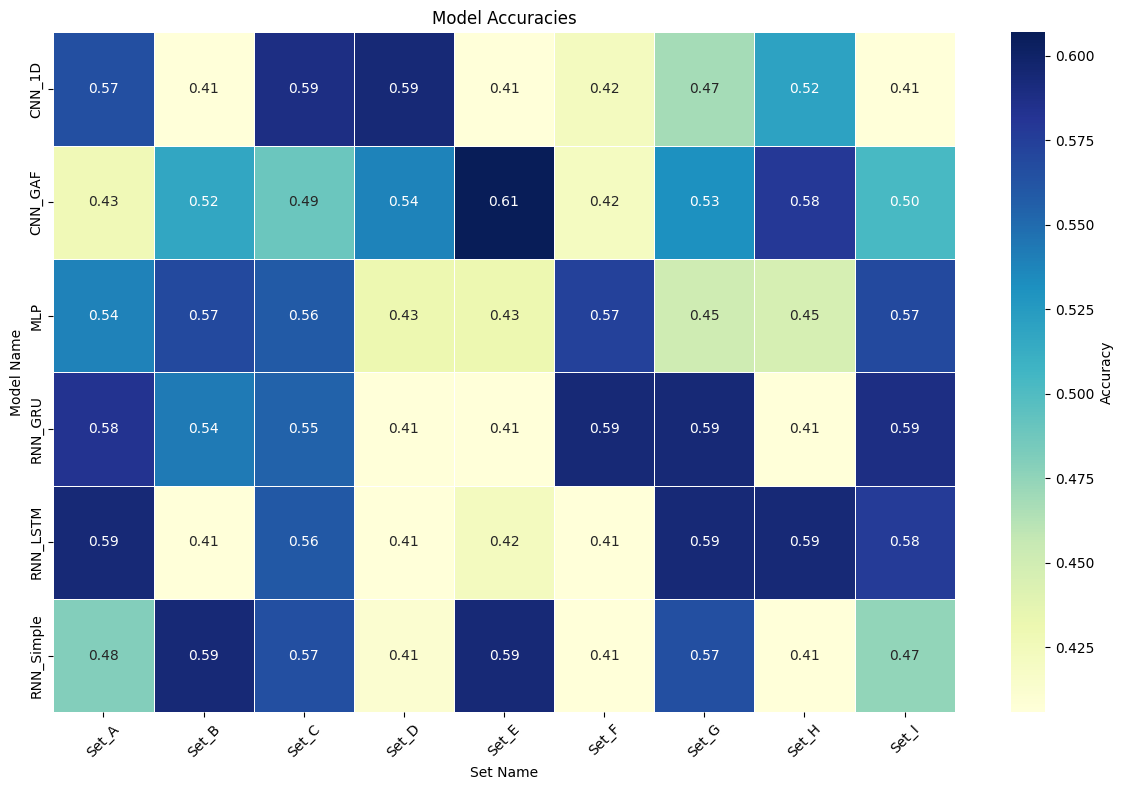

In [ ]:
print("Total number of models:", len(accuracies_dict))
print("Number of models with accuracy > 0.5:", sum(1 for accuracy in accuracies_dict.values() if accuracy > 0.5))

df_accuracies = pd.DataFrame(
    accuracies_dict.items(),
    columns=['(set_name, model_name)', 'Accuracy']
)
df_accuracies[['Set Name', 'Model Name']] = pd.DataFrame(df_accuracies['(set_name, model_name)'].tolist(), index=df_accuracies.index)
df_accuracies = df_accuracies.drop(columns=['(set_name, model_name)'])
df_accuracies = df_accuracies[['Set Name', 'Model Name', 'Accuracy']]
matrix_accuracies = df_accuracies.pivot(index='Model Name', columns='Set Name', values='Accuracy')
display(matrix_accuracies.fillna(0))


plt.figure(figsize=(12, 8))
sns.heatmap(matrix_accuracies, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=.5, cbar_kws={"label": "Accuracy"})
plt.title('Model Accuracies')
plt.xlabel('Set Name')
plt.ylabel('Model Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

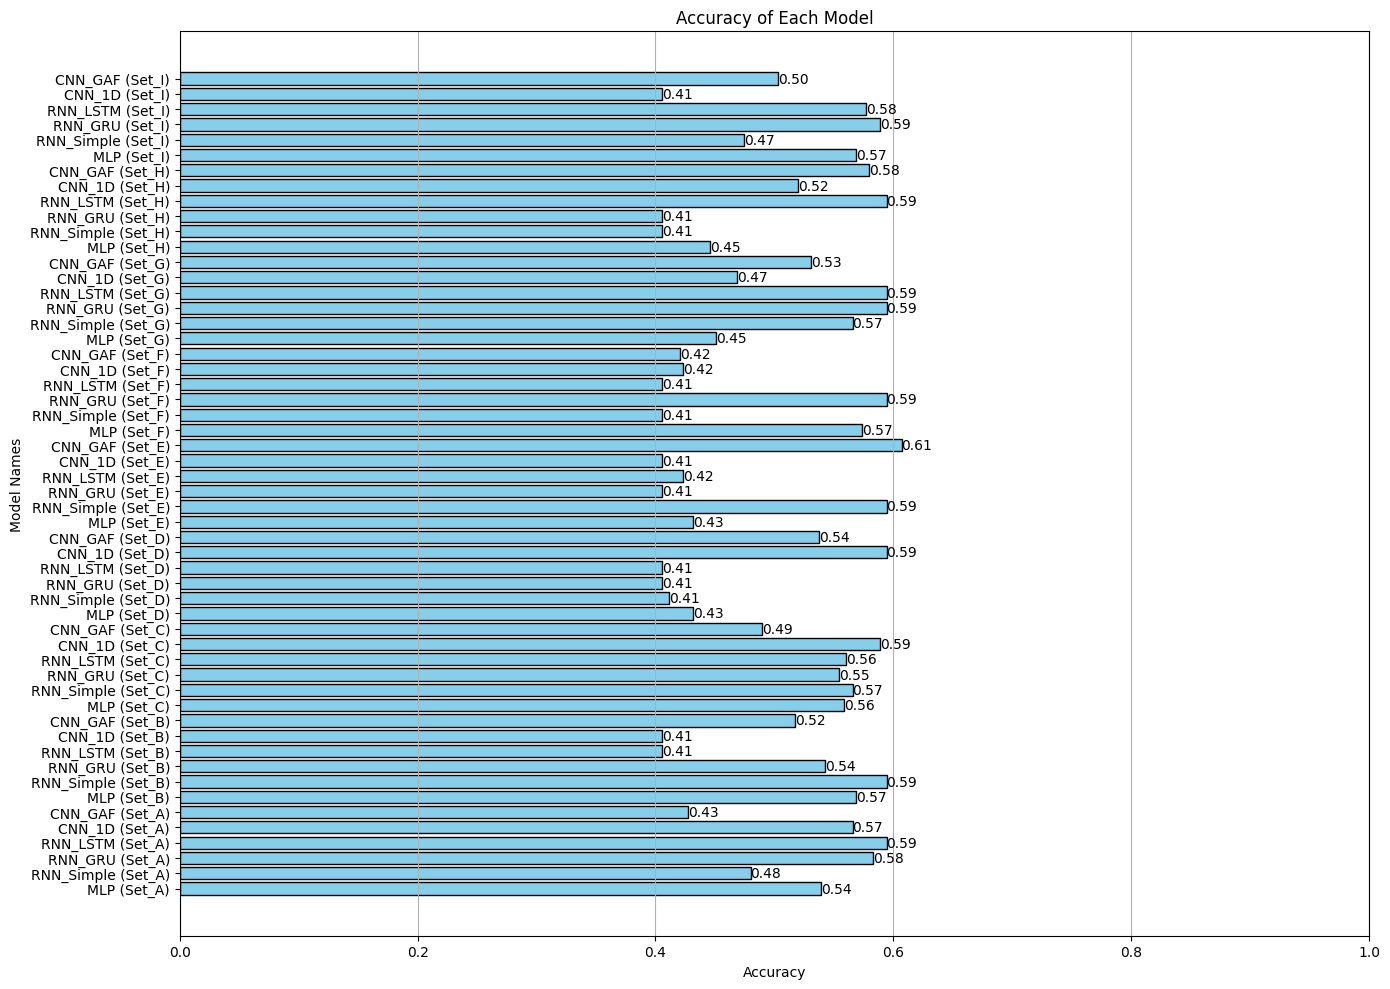

In [ ]:
# Prepare data for plotting using accuracies_dict
model_names = [f"{name} ({set_name})" for set_name, name in accuracies_dict.keys()]
model_accuracies = list(accuracies_dict.values())

# Plotting the accuracies for each model
plt.figure(figsize=(14, 10))  # Increased figure size for better visibility
bars = plt.barh(model_names, model_accuracies, color='skyblue', edgecolor='black')

# Adding text annotations to the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.2f}",
             va='center', ha='left', fontsize=10)

plt.xlabel('Accuracy')
plt.ylabel('Model Names')
plt.title('Accuracy of Each Model')
plt.xlim(0, 1)  # Set x-axis limits for accuracy from 0 to 1
plt.grid(axis='x')
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Calculate average accuracy across set_name and name
average_accuracy_per_set = {}
average_accuracy_per_model = {}

for (set_name, name), accuracy in accuracies_dict.items():
    # Average accuracy across set_name
    if set_name not in average_accuracy_per_set:
        average_accuracy_per_set[set_name] = []
    average_accuracy_per_set[set_name].append(accuracy)

    # Average accuracy across model names
    if name not in average_accuracy_per_model:
        average_accuracy_per_model[name] = []
    average_accuracy_per_model[name].append(accuracy)

# Print average accuracy for each set_name
print("\nAverage Accuracy Across Set Names:")
for set_name, accuracies in average_accuracy_per_set.items():
    avg_accuracy = np.mean(accuracies)
    print(f"{set_name}: {avg_accuracy:.4f}")

# Print average accuracy for each model name
print("\nAverage Accuracy Across Model Names:")
for name, accuracies in average_accuracy_per_model.items():
    avg_accuracy = np.mean(accuracies)
    print(f"{name}: {avg_accuracy:.4f}")


Average Accuracy Across Set Names:
Set_A: 0.5316
Set_B: 0.5057
Set_C: 0.5528
Set_D: 0.4644
Set_E: 0.4778
Set_F: 0.4705
Set_G: 0.5341
Set_H: 0.4919
Set_I: 0.5196

Average Accuracy Across Model Names:
MLP: 0.5076
RNN_Simple: 0.4997
RNN_GRU: 0.5194
RNN_LSTM: 0.5067
CNN_1D: 0.4863
CNN_GAF: 0.5126


In [ ]:
# Determine the best model across all (set_name, model_name) pairs
best_model = max(accuracies_dict, key=accuracies_dict.get)
best_model_accuracy = accuracies_dict[best_model]

# Print the best model and its accuracy
print(f"\nBest Model: {best_model[1]} on {best_model[0]} with Accuracy: {best_model_accuracy:.4f}")


Best Model: CNN_GAF on Set_E with Accuracy: 0.6069


## **10. Profitabilty Metrics**

In [ ]:
def calculate_sharpe_ratio(returns, risk_free_rate=0.02):
    """Compute Sharpe Ratio: (Mean Return - Risk-Free Rate) / Std Dev of Returns"""
    excess_returns = returns - risk_free_rate / 252  # Convert annual risk-free rate to daily
    return np.mean(excess_returns) / np.std(excess_returns)

def backtest(y_true, y_pred, Ret_vector):
    """Generate Buy/Sell/Hold signals and compute trading returns"""
    actions = []
    daily_returns = [0]  # Start with zero return for the first day
    portfolio_value = 1  # Assume starting capital is $1

    for i in range(1, len(y_pred)):
        if y_pred[i] == 1:
            actions.append("BUY")
            daily_returns.append((y_true[i] - y_true[i-1]) / y_true[i-1])  # Percentage return
        elif y_pred[i] == 0:
            actions.append("SELL")
            daily_returns.append(-(y_true[i] - y_true[i-1]) / y_true[i-1])  # Short selling profit
        else:
            actions.append("HOLD")
            daily_returns.append(0)  # No return for Hold

    daily_returns = np.array(daily_returns)
    cumulative_returns = np.cumprod(1 + daily_returns)  # Compute cumulative return over time
    max_drawdown = np.max(np.maximum.accumulate(cumulative_returns) - cumulative_returns)

    sharpe_ratio = calculate_sharpe_ratio(daily_returns)
    annualized_volatility = np.std(daily_returns) * np.sqrt(252)

    return actions, cumulative_returns, sharpe_ratio, max_drawdown, annualized_volatility


    actions = []
    for i in range(1, len(y_pred)):
        if y_pred[i] == 1:
            actions.append("BUY")
        elif y_pred[i] == 0:
            actions.append("SELL")
        else:
            actions.append("HOLD")
    return actions

In [ ]:
for set_name, columns in Sets.items():
    for name, model in models[set_name].items():
        if name in ['MLP']:
            y_prob = model.predict(X_test[set_name])
            y_pred = np.where(y_prob > 0.50, 1, 0)
            actions, cum_returns, sharpe_ratio, max_drawdown, volatility = backtest(y_test, y_pred)
        else:
            y_prob = model.predict(X_test_seq[set_name])
            y_pred = np.where(y_prob > 0.50, 1, 0)
            actions, cum_returns, sharpe_ratio, max_drawdown, volatility = backtest(y_test_seq, y_pred)

        print(f"\n🔹 {name} - {set_name} Model Performance 🔹")
        print(f"📈 Sharpe Ratio: {sharpe_ratio:.4f}")
        print(f"📉 Max Drawdown: {max_drawdown:.4%}")
        print(f"⚡ Annualized Volatility: {volatility:.4%}")
        print(f"💰 Final Cumulative Return: {cum_returns[-1]:.4f}\n")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


ValueError: too many values to unpack (expected 5)

All four of them have negative sharpe ratios with MLP outperforming all of them. They have almost similar annual volatility.
1. MLP has the highest cumulative returns and lowest max drawdowns.
2. RNN and 3. LSTM perform poorly as both have high max drawdowns
4. CNN has the highest max drawdown and high volatility.
All of them have negative sharpe ratios

## **11. Visualisation of Cummulative Returns**

In [ ]:
def CumRet(y_pred, Ret_vector, test_time):
    df_predictions = pd.DataFrame(
        {
            "Date": test_time.flatten(),
            "Pred": y_pred.flatten(),
            "Ret": (Ret_vector.flatten()),
        }
    )
    df_predictions.Date = pd.to_datetime(df_predictions.Date, format="%YYYY-%mm-%dd")
    df_predictions["Positions"] = np.where(df_predictions["Pred"] > 0.5, 1, -1)
    df_predictions["Strat_ret"] = df_predictions["Positions"].shift(1) * df_predictions["Ret"]
    df_predictions["CumRet"] = df_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
    return df_predictions

Benchmarket strategy of Buy and Hold give 0.15286834468071375 return.


<ipython-input-82-f293cc1abb6e>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  last_cum_ret_df = pd.concat([last_cum_ret_df, new_row], ignore_index=True)


RNN_LSTM - Set_A outperforms Buy and Hold strategy
MLP - Set_B outperforms Buy and Hold strategy
RNN_Simple - Set_B outperforms Buy and Hold strategy
RNN_GRU - Set_B outperforms Buy and Hold strategy
RNN_Simple - Set_C outperforms Buy and Hold strategy
CNN_1D - Set_D outperforms Buy and Hold strategy
RNN_Simple - Set_E outperforms Buy and Hold strategy
RNN_GRU - Set_F outperforms Buy and Hold strategy
RNN_Simple - Set_G outperforms Buy and Hold strategy
RNN_GRU - Set_G outperforms Buy and Hold strategy
RNN_LSTM - Set_G outperforms Buy and Hold strategy
RNN_LSTM - Set_H outperforms Buy and Hold strategy
MLP - Set_I outperforms Buy and Hold strategy


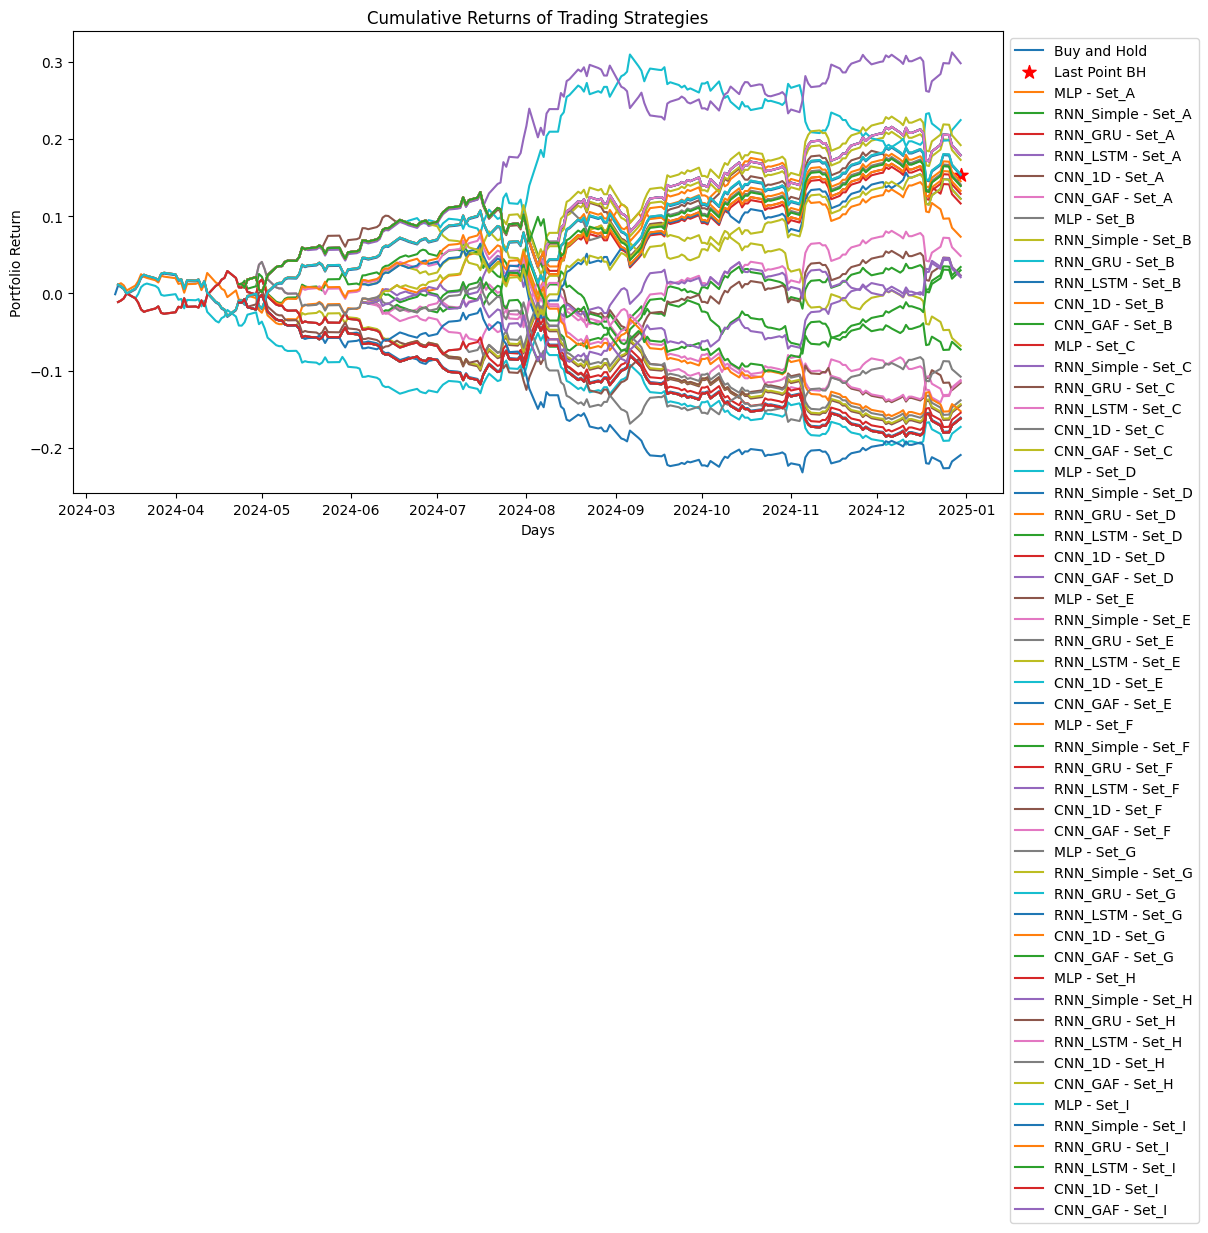

Total number of models: 54
Number of models that outperform Buy and Hold: 13


In [ ]:
plt.figure(figsize=(12,6))

BH_df = pd.DataFrame({"Date": test_time.flatten(), "Ret": Ret_vector.flatten()})
BH_df["bhRet"] = BH_df["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
plt.plot(BH_df['Date'], BH_df['bhRet'], label="Buy and Hold")

last_point = BH_df.iloc[-1]  # Get the last row
plt.scatter(last_point['Date'], last_point['bhRet'], color='red', s=100, marker='*', label='Last Point BH')
print(f"Benchmarket strategy of Buy and Hold give {BH_df['bhRet'].iloc[-1]} return.")

last_cum_ret_df = pd.DataFrame(columns=["Model", "Set Name", "Last CumRet"])
total_models = 0
outperforming_models = 0

for set_name, columns in Sets.items():
    for name, model in models[set_name].items():
        total_models += 1
        if name in ['MLP']:
            y_prob = model.predict(X_test[set_name], verbose=0)
            y_pred = np.where(y_prob > 0.50, 1, 0)
            df = CumRet(y_pred, Ret_vector, test_time)
        elif name in ["CNN_GAF", "Xception", "GoogLeNet"]:
            y_prob = model.predict(X_test_gaf[set_name], verbose=0)
            y_pred = np.where(y_prob > 0.50, 1, 0)
            df = CumRet(y_pred, Ret_vector_gaf, test_time_gaf)
        else:
            y_prob = model.predict(X_test_seq[set_name], verbose=0)
            y_pred = np.where(y_prob > 0.50, 1, 0)
            df = CumRet(y_pred, Ret_vector_seq, test_time_seq)
        last_cum_ret = df['CumRet'].iloc[-1]
        new_row = pd.DataFrame({"Model": [name], "Set Name": [set_name], "Last CumRet": [last_cum_ret]})
        last_cum_ret_df = pd.concat([last_cum_ret_df, new_row], ignore_index=True)

        plt.plot(df['Date'], df['CumRet'], label=f"{name} - {set_name}")

        if df['CumRet'].iloc[-1] > BH_df['bhRet'].iloc[-1]:
            outperforming_models += 1
            print(f"{name} - {set_name} outperforms Buy and Hold strategy")

plt.title("Cumulative Returns of Trading Strategies")
plt.xlabel("Days")
plt.ylabel("Portfolio Return")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

print(f"Total number of models: {total_models}")
print(f"Number of models that outperform Buy and Hold: {outperforming_models}")

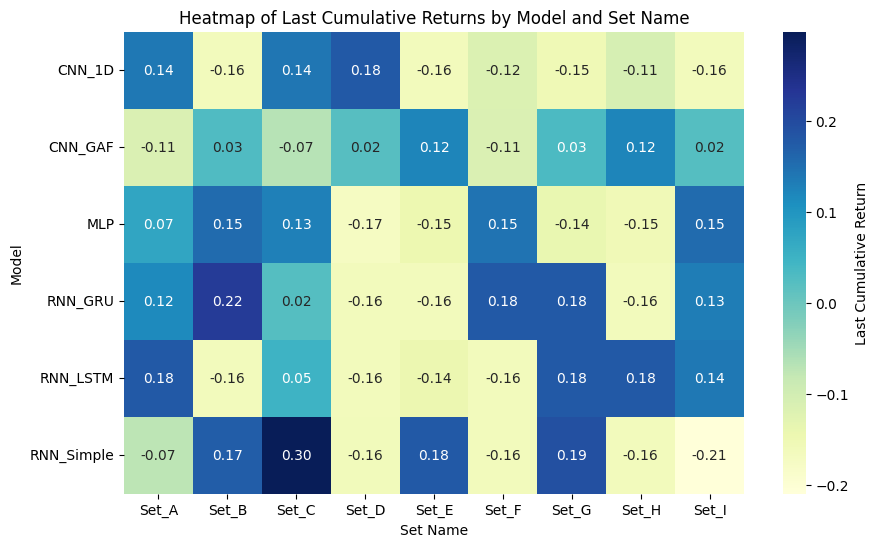

In [ ]:
heatmap_data = last_cum_ret_df.pivot(index='Model', columns='Set Name', values= "Last CumRet")

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".2f", cbar_kws={"label": "Last Cumulative Return"})
plt.title("Heatmap of Last Cumulative Returns by Model and Set Name")
plt.xlabel("Set Name")
plt.ylabel("Model")
plt.show()

# **Traditional Statistical Model for comparison with our NNs**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

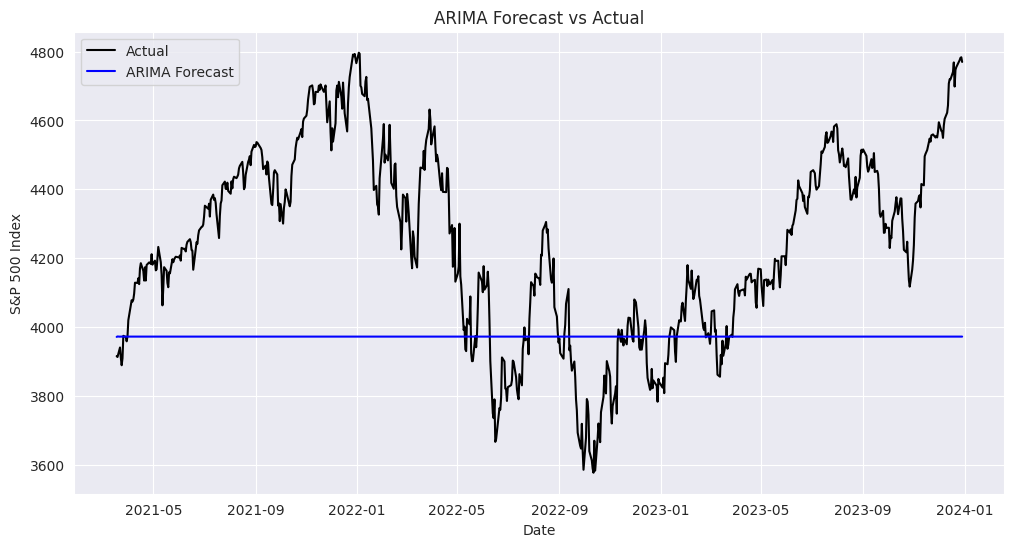

ARIMA MSE: 150088.3193
ARIMA MAE: 321.7229
ARIMA RMSE: 387.4123


In [ ]:
# Fetch S&P 500 data from 2010 to 2024
data['Returns'] = data['Close'].pct_change().dropna()

# Train-test split (80% train, 20% test)
train_size = int(len(data) * 0.8)
train, test = data['Close'][:train_size], data['Close'][train_size:]

# Fit ARIMA model
arima_model = ARIMA(train, order=(1,1,1))
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(test))

# Evaluate ARIMA model
mse_arima = mean_squared_error(test, arima_pred)
mae_arima = mean_absolute_error(test, arima_pred)
rmse_arima = np.sqrt(mse_arima)

# Visualization
plt.figure(figsize=(12,6))
plt.plot(data.index[train_size:], test, label='Actual', color='black')
plt.plot(data.index[train_size:], arima_pred, label='ARIMA Forecast', color='blue')
plt.xlabel('Date')
plt.ylabel('S&P 500 Index')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()

print(f'ARIMA MSE: {mse_arima:.4f}')
print(f'ARIMA MAE: {mae_arima:.4f}')
print(f'ARIMA RMSE: {rmse_arima:.4f}')


ARIMA is not capturing data well and accurately as shown by higher MSE,RMSE. However a relatively lower MAE shows the ARIMA has captured the direction relatively well even as shown by the graph above.
The higher error metrics figures shows ARIMA is not complex enough to capture underlying patterns in the data. There is higher chance of overfitting and underfitting.
Overally the ARIMA performs poorly against our neural networks which is not surprising.

## **Appendix**

**Relative Strength Index (RSI)**

RSI is a momentum oscillator, which measures the speed and change of price movements, and could indicate whether the stock is overbought or oversold.
$$ \text{RSI} = 100 - \left(\dfrac{100}{1+\frac{\text{Average Gain}}{\text{Average Loss}}}\right) $$

Typically, when RSI > 70, it is considered as overbought; when RSI < 30, it is considered as oversold.

**Moving Average Convergence Divergence (MACD)**

$$ \text{MACD Line} = \text{EMA}_{12} - \text{EMA}_{26} $$

$$ \text{Signal Line} = \text{EMA}_{9} (\text{MACD Line}) $$

**Signal-line crossover** : When MACD Line cross Signal Line
- Cross up ⇒ Bull signal
- Cross down ⇒ Bear signal

**Zero crossover** : When MACD Line changes sign
- -ve to +ve ⇒ Bull signal
- +ve to -ve ⇒ Bear signal

**Divergence** : high/low for Price vs MACD
- Price with lower low while MACD with higher low ⇒ bullish divergence
- Price with higher high while MACD with lower high ⇒ bearish divergence

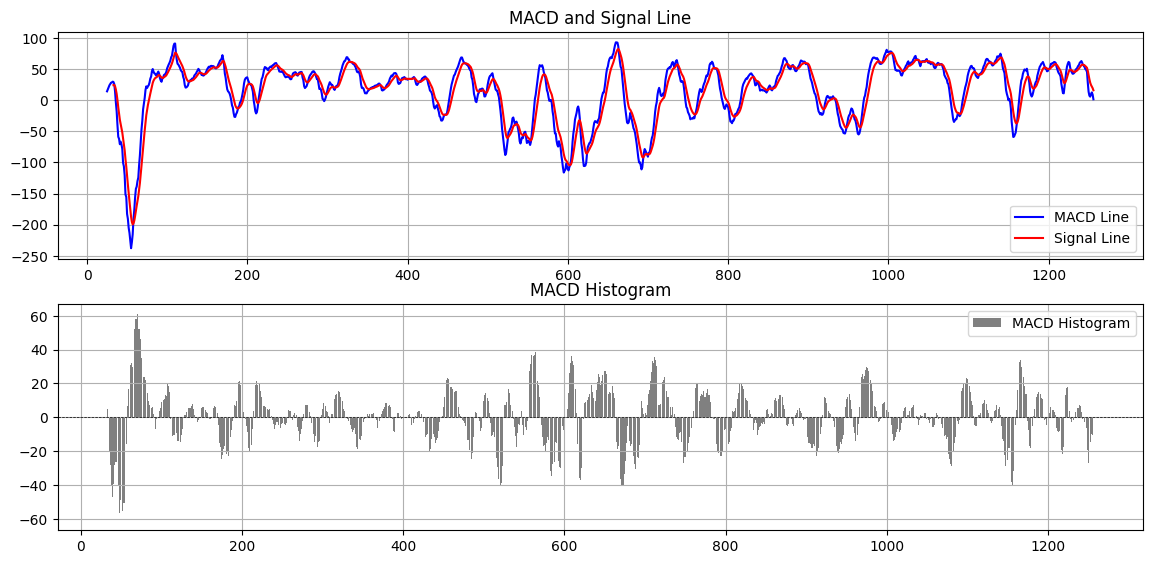

In [ ]:
plt.figure(figsize=(14, 10))
plt.subplot(3, 1, 1)
plt.plot(input_df['MACD'], label='MACD Line', color='blue')
plt.plot(input_df['MACD_Signal'], label='Signal Line', color='red')
plt.title('MACD and Signal Line')
plt.legend()
plt.grid()
plt.subplot(3, 1, 2)
plt.bar(input_df.index, input_df['MACD_Hist'], label='MACD Histogram', color='gray')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.title('MACD Histogram')
plt.legend()
plt.grid()

**On-Balance Volume (OBV)**

OBV measures the buying and selling pressure, by adding the volumn when price increase in a day, and do the the opposite when price movement is in another direction.

When today's closing price > yesterday's closing price:
- OBV = Yesterday’s OBV + Today’s Volume

When today's closing price < yesterday's closing price:
- OBV = Yesterday’s OBV – Today’s Volume

Else:
- OBV = Yesterday’s OBV

**Accumulation/Distribution Line (A/D Line)**

A/D Line measures the cumulative flow of money through a security. Increasing A/D line suggests buying pressure, and decreasing A/D line suggest selling pressure. It is computed through 3 steps:

Money Flow Multiplier (MFM):
$$ \text{MFM} = \dfrac{(\text{Close} - \text{Low})-(\text{High}-\text{Close})}{\text{High} - \text{Low}} $$

Money Flow Volume (MFV):
$$ \text{MFV} = \text{MFM} * \text{Volume} $$

A/D Line:
$$ \text{A/D Line} = \text{Yesterday's A/D Line} + \text{MFV} $$

**Average True Range (ATR)**

ATR is used to measure volatility.

True Range (TR):
$$ \text{TR} = Max(\text{Current High}-\text{Current Low}, \text{Current High}-\text{Previous Close}, \text{Current Low}-\text{Previous Close}) $$

Average True Range (ATR):
$$ \text{ATR} = EMA(\text{TR}, \text{14 days}) $$

where EMA is exponential moving average

### **Exploratory Data Analysis**

**S&P 500 in past 10 years**

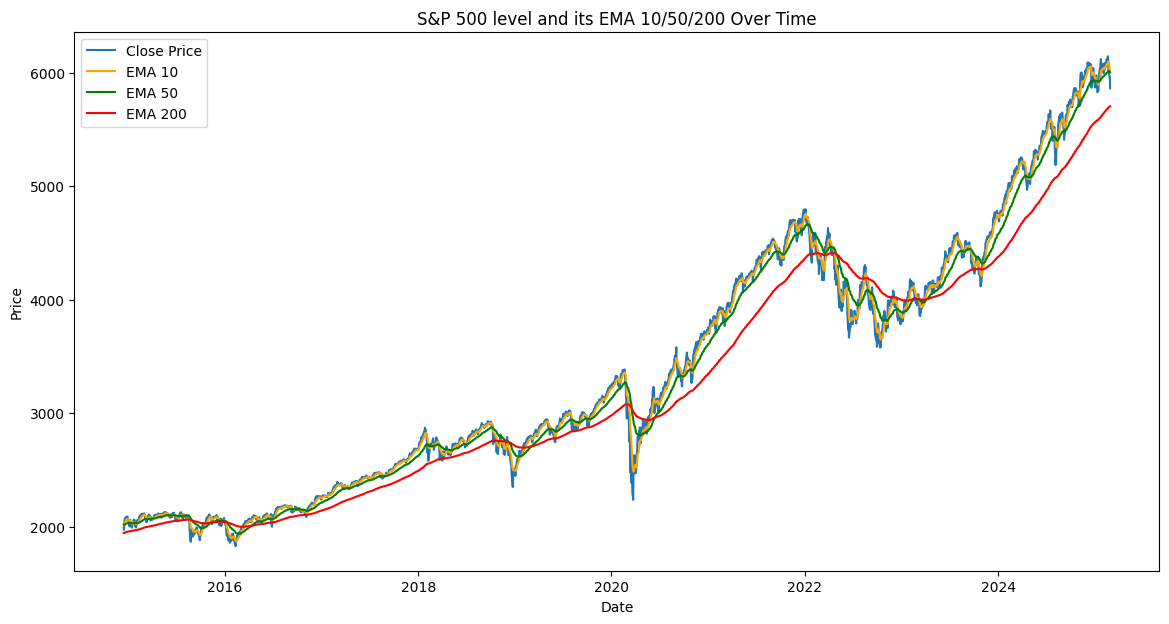

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(data_df['Date'], data_df['Close'], label='Close Price')
plt.plot(data_df['Date'], data_df['EMA10'], label='EMA 10', color='orange')
plt.plot(data_df['Date'], data_df['EMA50'], label='EMA 50', color='green')
plt.plot(data_df['Date'], data_df['EMA200'], label='EMA 200', color='red')

plt.title('S&P 500 level and its EMA 10/50/200 Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

S&P 500 has shown an overall upward trend in the past 10 years, especially in the period of 2020 to 2021 and 2024 onwards with a steep slope for strong increase. It makes sense in a way that the market index should gradually increase in the long term due to inflation. In recent years, due to the stimulation from government policy such as quantitative easing, we could observe a steeper slope of increase. Ideally our model should capture this long-term increasing trend to predict more buy signals, and at the same time be able to avoid some large drawdown in the period.

**SMA/EMA**

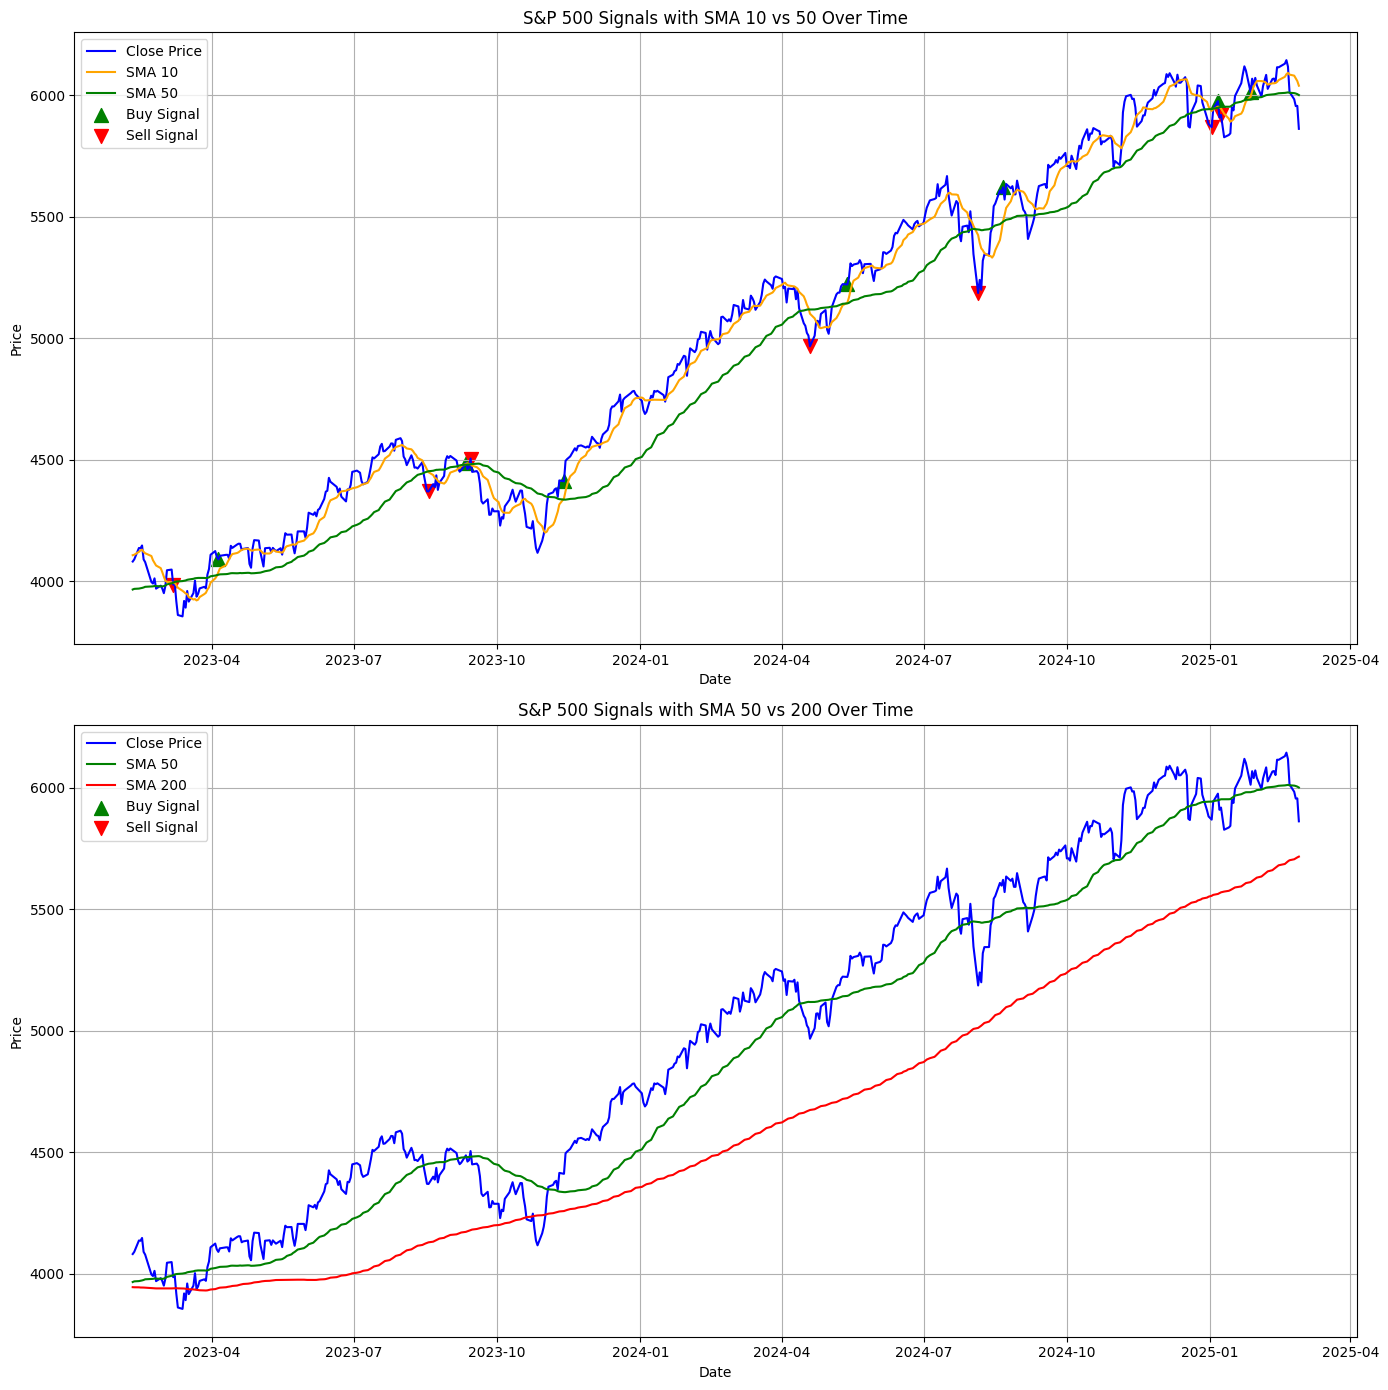

In [ ]:
# @title
train_size = int(0.8 * len(data_df))
test_size = len(data_df) - int(0.8 * len(data_df))
plot_df = data_df.tail(test_size)
#plot_df = data_df[(data_df['Date'] >= '2020-01-01') & (data_df['Date'] <= '2020-12-31')]
fig, axs = plt.subplots(2, 1, figsize=(14, 14))

# SMA 10 vs 50
axs[0].plot(plot_df['Date'], plot_df['Close'], label='Close Price', color='blue')
axs[0].plot(plot_df['Date'], plot_df['SMA10'], label='SMA 10', color='orange')
axs[0].plot(plot_df['Date'], plot_df['SMA50'], label='SMA 50', color='green')
buy_signals = plot_df[plot_df['SMA_Cross'] == 1]
axs[0].scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', label='Buy Signal', s=100)
sell_signals = plot_df[plot_df['SMA_Cross'] == -1]
axs[0].scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', label='Sell Signal', s=100)

axs[0].set_title('S&P 500 Signals with SMA 10 vs 50 Over Time')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
axs[0].legend()
axs[0].grid()

# SMA 50 vs 200
axs[1].plot(plot_df['Date'], plot_df['Close'], label='Close Price', color='blue')
axs[1].plot(plot_df['Date'], plot_df['SMA50'], label='SMA 50', color='green')
axs[1].plot(plot_df['Date'], plot_df['SMA200'], label='SMA 200', color='red')
buy_signals = plot_df[plot_df['SMA_Cross_50_200'] == 1]
axs[1].scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', label='Buy Signal', s=100)
sell_signals = plot_df[plot_df['SMA_Cross_50_200'] == -1]
axs[1].scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', label='Sell Signal', s=100)

# Titles and labels for the second subplot
axs[1].set_title('S&P 500 Signals with SMA 50 vs 200 Over Time')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price')
axs[1].legend()
axs[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

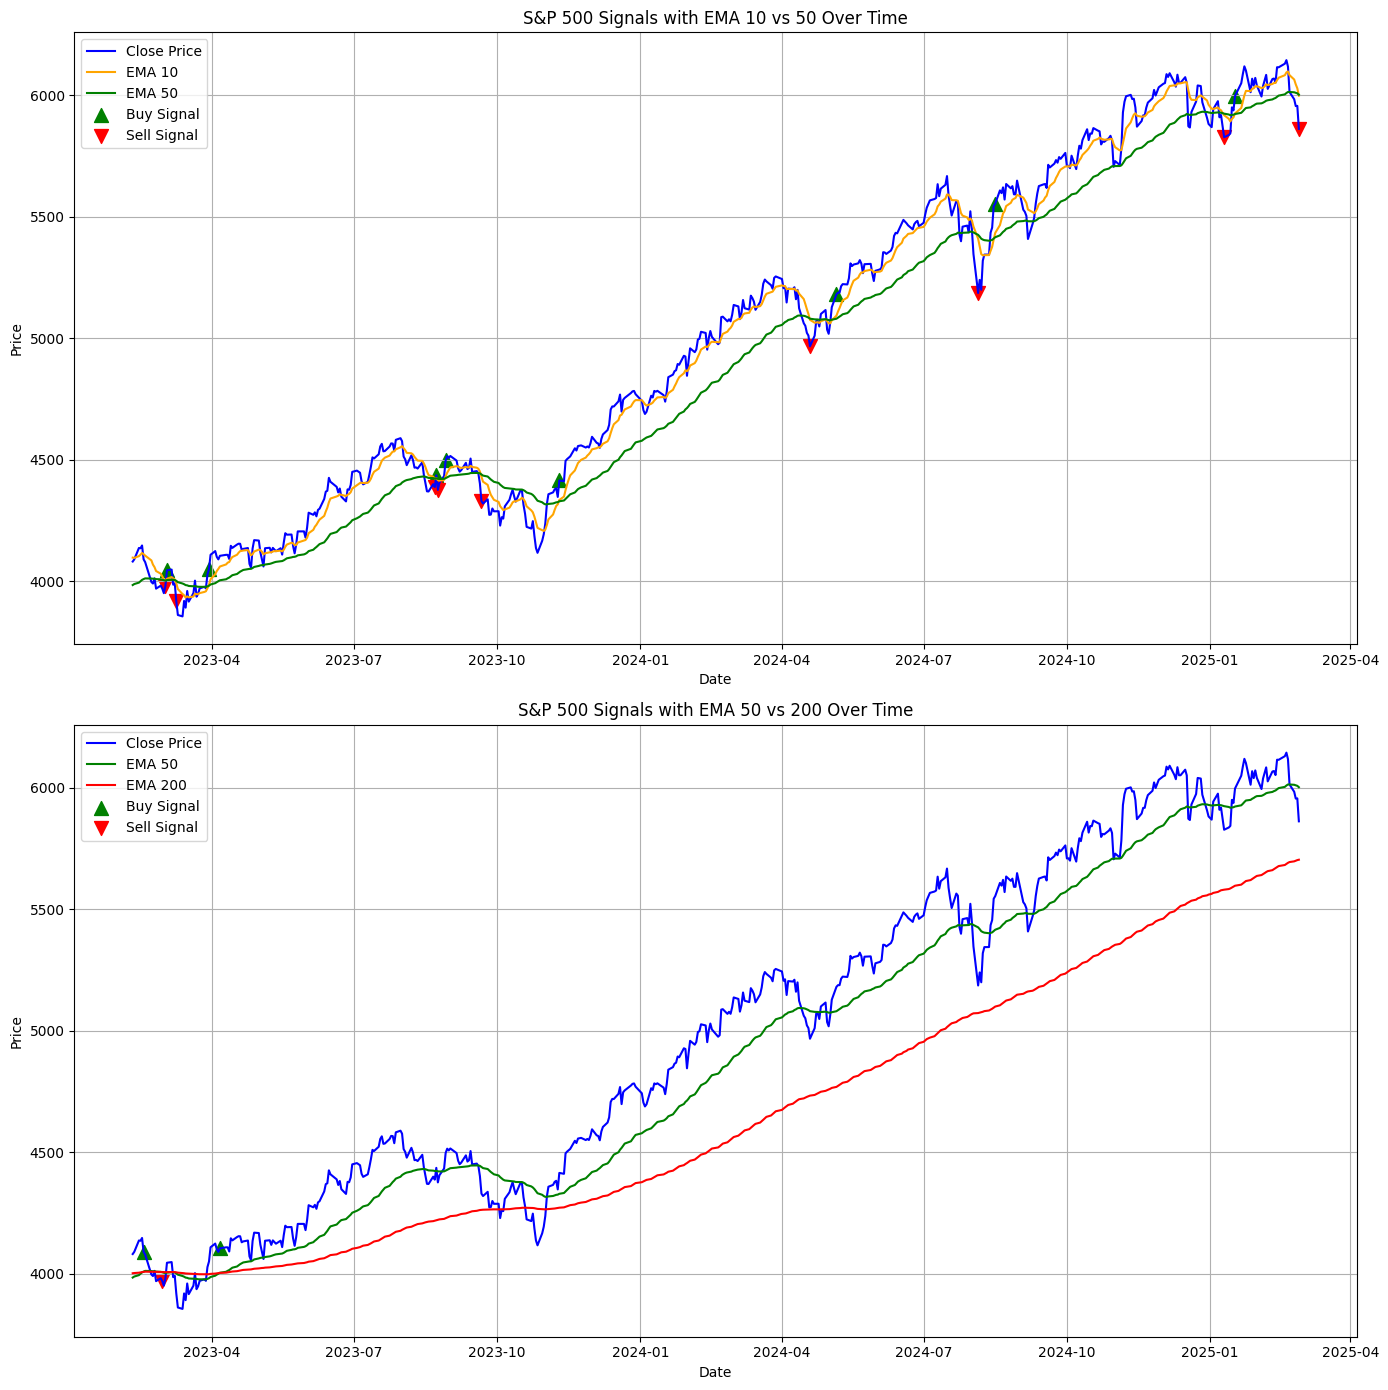

In [ ]:
# @title
train_size = int(0.8 * len(data_df))
test_size = len(data_df) - int(0.8 * len(data_df))
plot_df = data_df.tail(test_size)
#plot_df = data_df[(data_df['Date'] >= '2020-01-01') & (data_df['Date'] <= '2020-12-31')]
fig, axs = plt.subplots(2, 1, figsize=(14, 14))

# EMA 10 vs 50
axs[0].plot(plot_df['Date'], plot_df['Close'], label='Close Price', color='blue')
axs[0].plot(plot_df['Date'], plot_df['EMA10'], label='EMA 10', color='orange')
axs[0].plot(plot_df['Date'], plot_df['EMA50'], label='EMA 50', color='green')
buy_signals = plot_df[plot_df['EMA_Cross'] == 1]
axs[0].scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', label='Buy Signal', s=100)
sell_signals = plot_df[plot_df['EMA_Cross'] == -1]
axs[0].scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', label='Sell Signal', s=100)

axs[0].set_title('S&P 500 Signals with EMA 10 vs 50 Over Time')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
axs[0].legend()
axs[0].grid()

# EMA 50 vs 200
axs[1].plot(plot_df['Date'], plot_df['Close'], label='Close Price', color='blue')
axs[1].plot(plot_df['Date'], plot_df['EMA50'], label='EMA 50', color='green')
axs[1].plot(plot_df['Date'], plot_df['EMA200'], label='EMA 200', color='red')
buy_signals = plot_df[plot_df['EMA_Cross_50_200'] == 1]
axs[1].scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', label='Buy Signal', s=100)
sell_signals = plot_df[plot_df['EMA_Cross_50_200'] == -1]
axs[1].scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', label='Sell Signal', s=100)

axs[1].set_title('S&P 500 Signals with EMA 50 vs 200 Over Time')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

In momentum trading, a common strategy is to buy when the short-term trend exceeds the long-term trend or vice versa. A simple to capture is by using SMA or EMA. A common approach is to use 10-day EMA as a short term trend, and 50-day EMA as a long term trend. We also explore the 50/200 and 1/50 pairs.

Using this approach for signal generation, we observe that it could avoid a large and long drawdown period. However, we observe it could perform badly in a quick recovery situation, and miss some profit due to late re-entry into the market.

**Trade signals from RSI Cross**

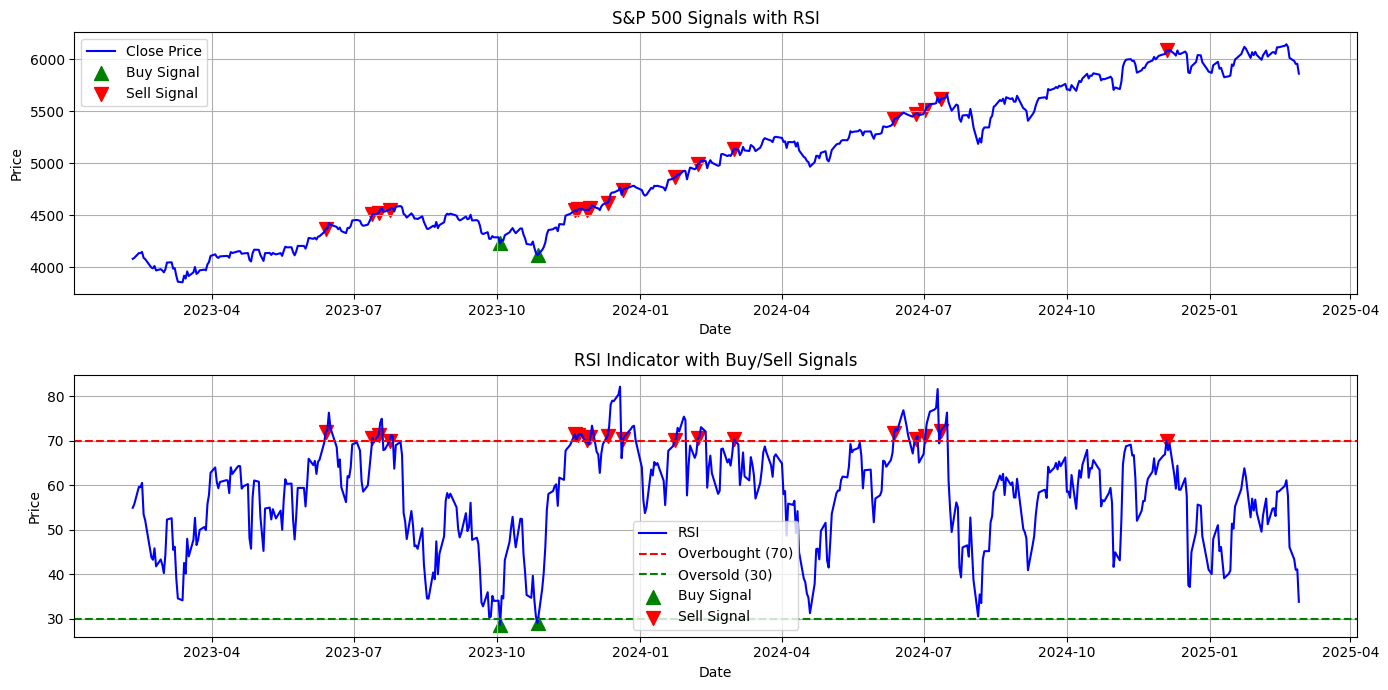

In [ ]:
# @title
train_size = int(0.8 * len(data_df))
test_size = len(data_df) - int(0.8 * len(data_df))
plot_df = data_df.tail(test_size)
fig, axs = plt.subplots(2, 1, figsize=(14, 7))

axs[0].plot(plot_df['Date'], plot_df['Close'], label='Close Price', color='blue')
buy_signals = plot_df[plot_df['RSI_Cross']==1]
axs[0].scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', label='Buy Signal', s=100)
sell_signals = plot_df[plot_df['RSI_Cross']==-1]
axs[0].scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', label='Sell Signal', s=100)

axs[0].set_title('S&P 500 Signals with RSI')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
axs[0].legend()
axs[0].grid()

axs[1].plot(plot_df['Date'], plot_df['RSI'], label='RSI', color='blue')
axs[1].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axs[1].axhline(30, color='green', linestyle='--', label='Oversold (30)')
axs[1].scatter(buy_signals['Date'], buy_signals['RSI'], marker='^', color='green', label='Buy Signal', s=100)
axs[1].scatter(sell_signals['Date'], sell_signals['RSI'], marker='v', color='red', label='Sell Signal', s=100)

# Titles and labels for the second subplot
axs[1].set_title('RSI Indicator with Buy/Sell Signals')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price')
axs[1].legend()
axs[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

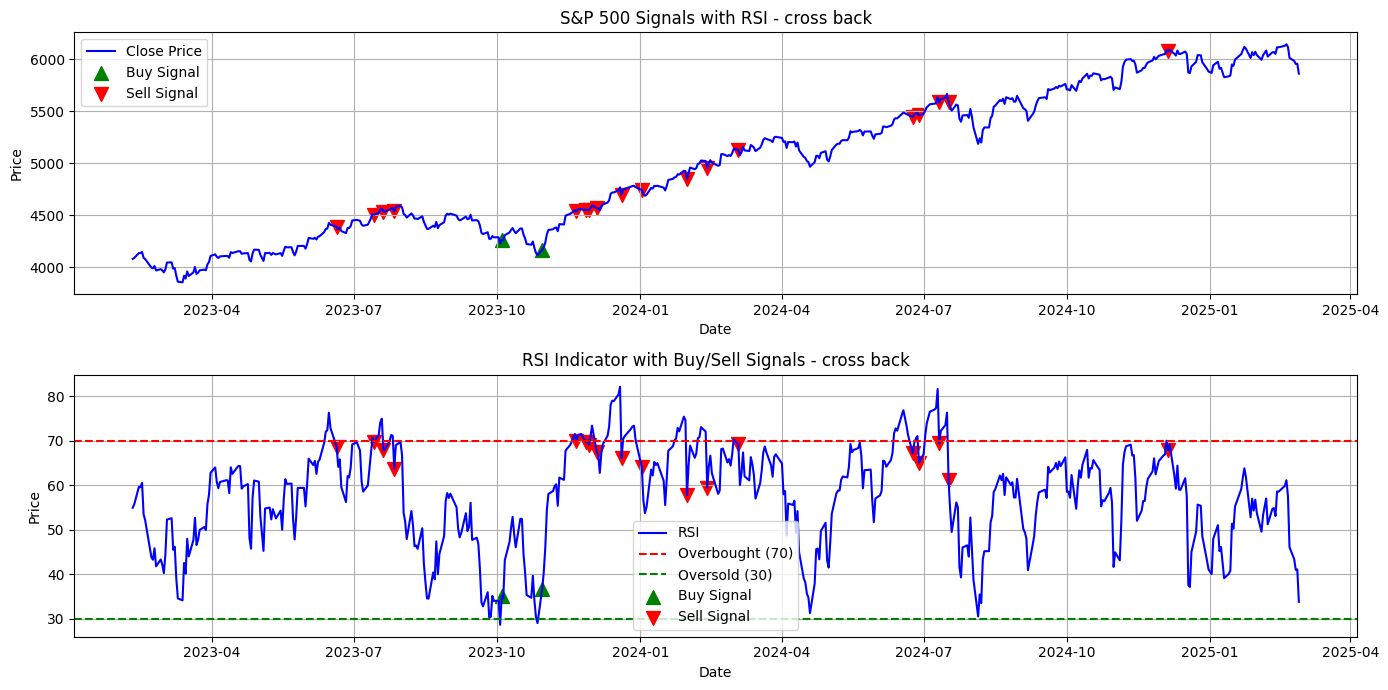

In [ ]:
# @title
train_size = int(0.8 * len(data_df))
test_size = len(data_df) - int(0.8 * len(data_df))
plot_df = data_df.tail(test_size)
fig, axs = plt.subplots(2, 1, figsize=(14, 7))

axs[0].plot(plot_df['Date'], plot_df['Close'], label='Close Price', color='blue')
buy_signals = plot_df[plot_df['RSI_Cross_back']==1]
axs[0].scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', label='Buy Signal', s=100)
sell_signals = plot_df[plot_df['RSI_Cross_back']==-1]
axs[0].scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', label='Sell Signal', s=100)

axs[0].set_title('S&P 500 Signals with RSI - cross back')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
axs[0].legend()
axs[0].grid()

axs[1].plot(plot_df['Date'], plot_df['RSI'], label='RSI', color='blue')
axs[1].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axs[1].axhline(30, color='green', linestyle='--', label='Oversold (30)')
axs[1].scatter(buy_signals['Date'], buy_signals['RSI'], marker='^', color='green', label='Buy Signal', s=100)
axs[1].scatter(sell_signals['Date'], sell_signals['RSI'], marker='v', color='red', label='Sell Signal', s=100)

# Titles and labels for the second subplot
axs[1].set_title('RSI Indicator with Buy/Sell Signals - cross back')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price')
axs[1].legend()
axs[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

RSI is a momentum oscillator, which measures the speed and change of price movements, and could indicate whether the stock is overbought or oversold. A common approach is to compare with 30 and 70 thresholds. When RSI is below 30, this indicates the stock is oversold and thus a buy signal. On the other hand, when it is above 70, this indicates the stock is overbought and thus a sell signal. We could either generate the buy/sell signal once the threshold is crossed, or only when the RSI crossed back the threshold. We have explored both approaches and compared their results.

We observe that RSI is able to generate buy signal when S&P500 hit a trough around Oct 2023. However, it has generated two many early sell signals, missing most of the upward trend.


**Trade signals from MACD Cross**

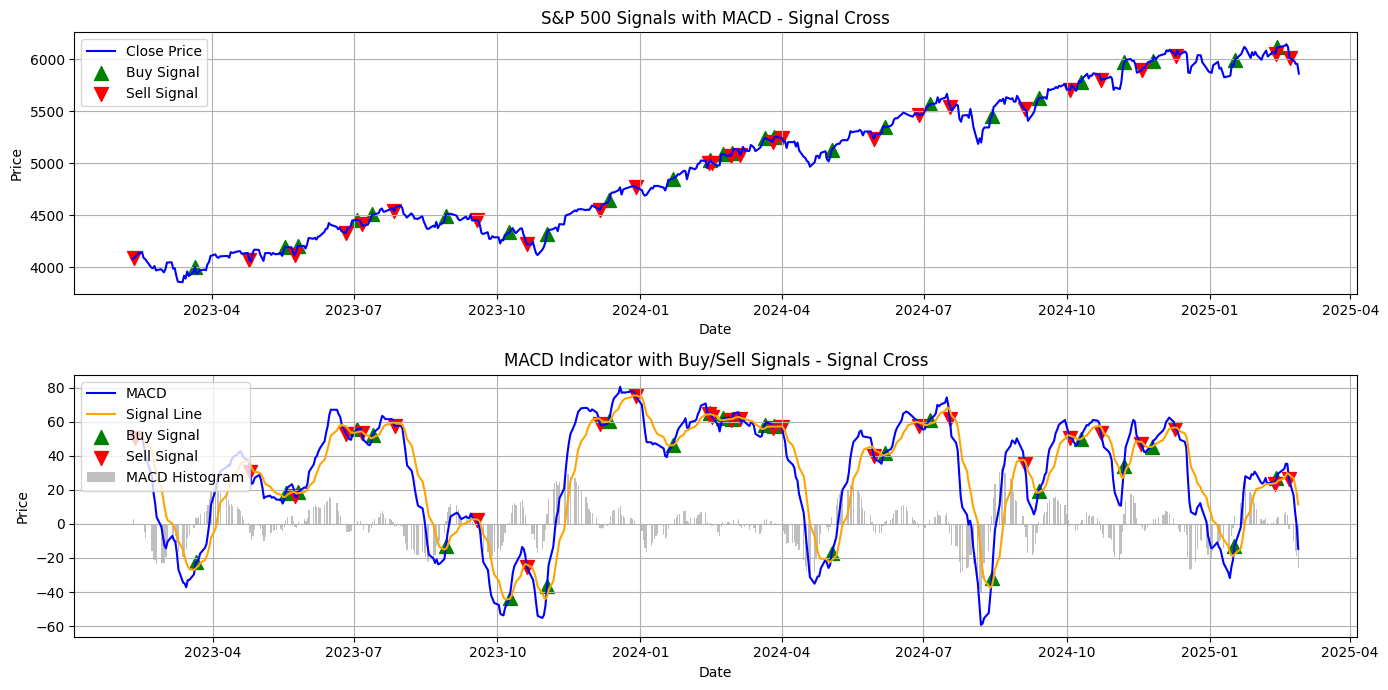

In [ ]:
train_size = int(0.8 * len(data_df))
test_size = len(data_df) - int(0.8 * len(data_df))
plot_df = data_df.tail(test_size)
fig, axs = plt.subplots(2, 1, figsize=(14, 7))

axs[0].plot(plot_df['Date'], plot_df['Close'], label='Close Price', color='blue')
buy_signals = plot_df[plot_df['MACD_Signal_Cross'] == 1]
axs[0].scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', label='Buy Signal', s=100)
sell_signals = plot_df[plot_df['MACD_Signal_Cross'] == -1]
axs[0].scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', label='Sell Signal', s=100)

axs[0].set_title('S&P 500 Signals with MACD - Signal Cross')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
axs[0].legend()
axs[0].grid()

axs[1].plot(plot_df['Date'], plot_df['MACD'], label='MACD', color='blue')
axs[1].plot(plot_df['Date'], plot_df['MACD_Signal'], label='Signal Line', color='orange')
axs[1].bar(plot_df['Date'], plot_df['MACD_Hist'], label='MACD Histogram', color='grey', alpha=0.5)
axs[1].scatter(buy_signals['Date'], buy_signals['MACD'], marker='^', color='green', label='Buy Signal', s=100)
axs[1].scatter(sell_signals['Date'], sell_signals['MACD'], marker='v', color='red', label='Sell Signal', s=100)

# Titles and labels for the second subplot
axs[1].set_title('MACD Indicator with Buy/Sell Signals - Signal Cross')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price')
axs[1].legend()
axs[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

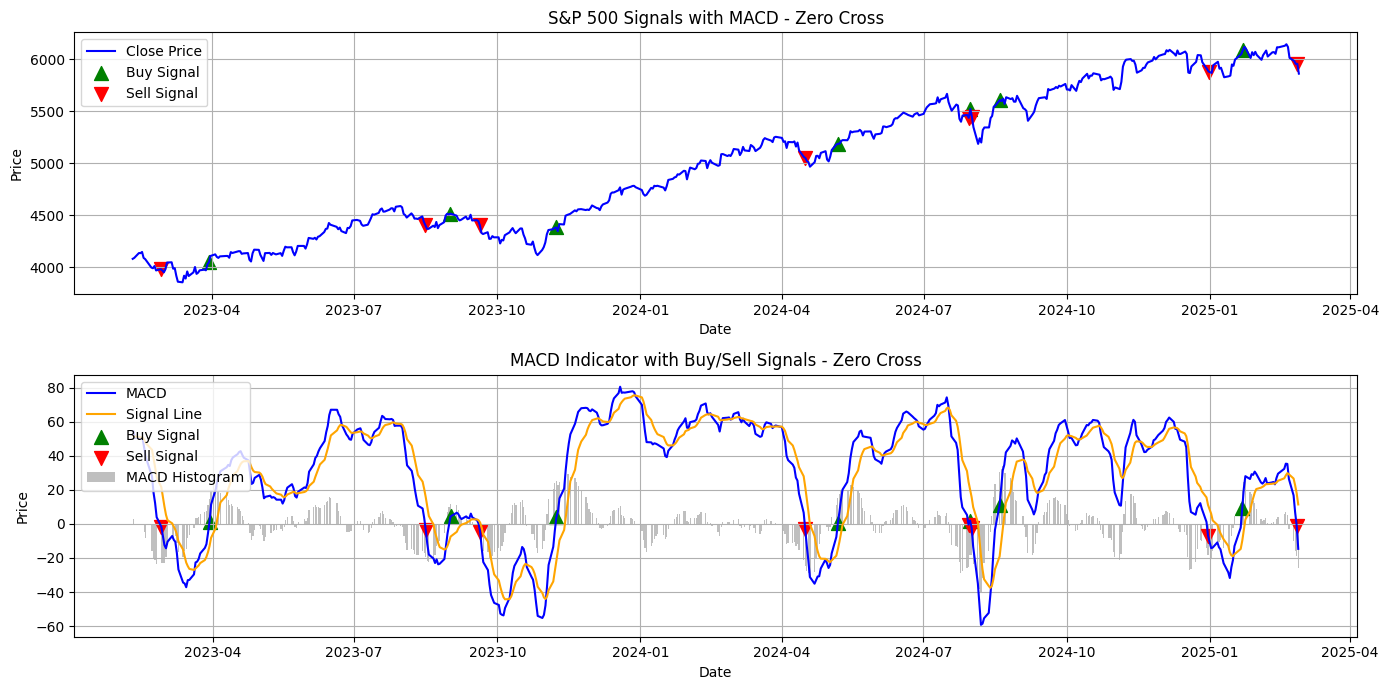

In [ ]:
train_size = int(0.8 * len(data_df))
test_size = len(data_df) - int(0.8 * len(data_df))
plot_df = data_df.tail(test_size)
fig, axs = plt.subplots(2, 1, figsize=(14, 7))

axs[0].plot(plot_df['Date'], plot_df['Close'], label='Close Price', color='blue')
buy_signals = plot_df[plot_df['MACD_Zero_Cross'] == 1]
axs[0].scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', label='Buy Signal', s=100)
sell_signals = plot_df[plot_df['MACD_Zero_Cross'] == -1]
axs[0].scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', label='Sell Signal', s=100)

axs[0].set_title('S&P 500 Signals with MACD - Zero Cross')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
axs[0].legend()
axs[0].grid()

axs[1].plot(plot_df['Date'], plot_df['MACD'], label='MACD', color='blue')
axs[1].plot(plot_df['Date'], plot_df['MACD_Signal'], label='Signal Line', color='orange')
axs[1].bar(plot_df['Date'], plot_df['MACD_Hist'], label='MACD Histogram', color='grey', alpha=0.5)
axs[1].scatter(buy_signals['Date'], buy_signals['MACD'], marker='^', color='green', label='Buy Signal', s=100)
axs[1].scatter(sell_signals['Date'], sell_signals['MACD'], marker='v', color='red', label='Sell Signal', s=100)

# Titles and labels for the second subplot
axs[1].set_title('MACD Indicator with Buy/Sell Signals - Zero Cross')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price')
axs[1].legend()
axs[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

MACD is a technical indicator to identify trends. MACD line is the gap between 12-day EMA and 26-day EMA while Signal line is the 9-day EMA of MACD line. Common approaches are to compare the MACD line against the Signal line or the Zero line (i.e. simple zero value). When the MACD line crosses above the Signal line (or Zero line), this shows the short-term momentum is getting strength relative to long-term momentum, and thus indicates a buy signal. Crossing in the opposite direction will then generate a sell signal.

We observe that when using the MACD x Signal cross, there are too many signals generated and become noisy. It may be able to avoid drawdown but is in general missing many of the upward trend. On the other hand, the signals generated by MACD x Zero cross look much better, but are still subject to the same limitation in SMA/EMA that perform badly in a quick recovery situation, and miss some profit due to late re-entry into the market. After all the Zero cross just becomes a 26d-EMA minus 12d-EMA.


**Trade signals from ADX x SMA Cross**

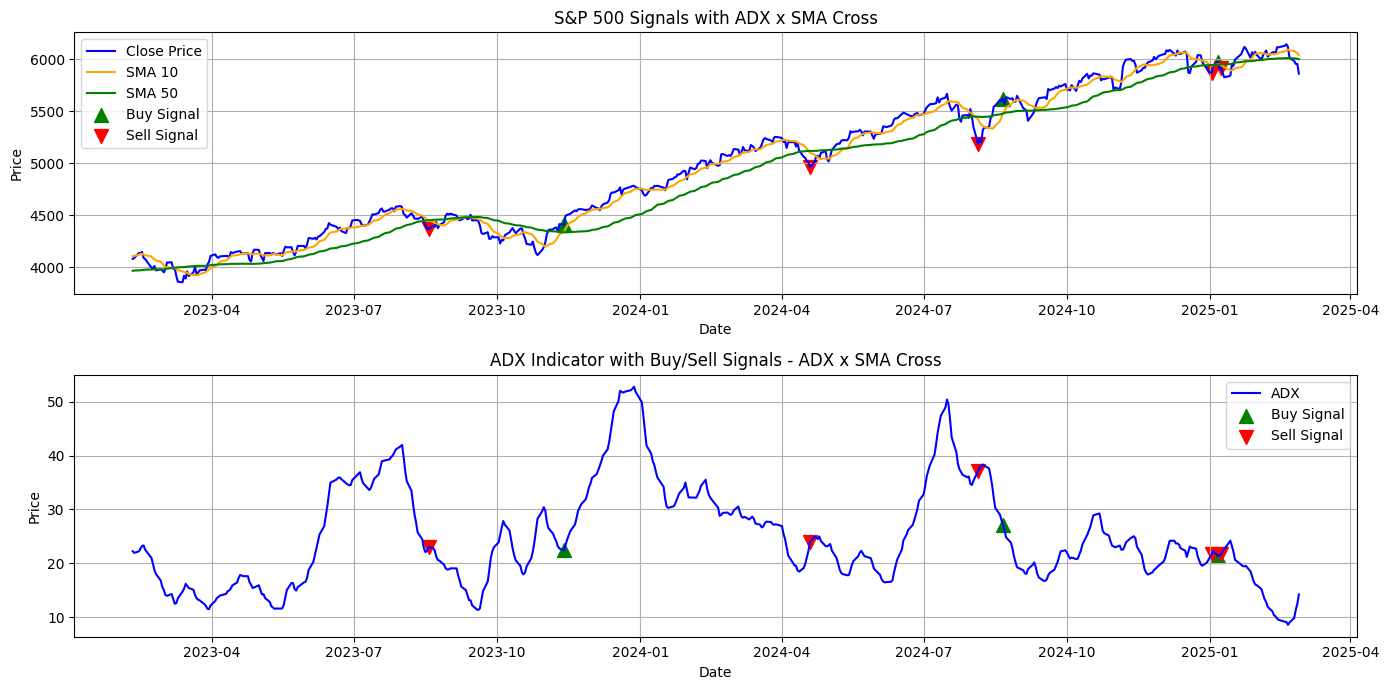

In [ ]:
train_size = int(0.8 * len(data_df))
test_size = len(data_df) - int(0.8 * len(data_df))
plot_df = data_df.tail(test_size)
fig, axs = plt.subplots(2, 1, figsize=(14, 7))

axs[0].plot(plot_df['Date'], plot_df['Close'], label='Close Price', color='blue')
axs[0].plot(plot_df['Date'], plot_df['SMA10'], label='SMA 10', color='orange')
axs[0].plot(plot_df['Date'], plot_df['SMA50'], label='SMA 50', color='green')
buy_signals = plot_df[plot_df['ADX_SMA_Cross'] == 1]
axs[0].scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', label='Buy Signal', s=100)
sell_signals = plot_df[plot_df['ADX_SMA_Cross'] == -1]
axs[0].scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', label='Sell Signal', s=100)

axs[0].set_title('S&P 500 Signals with ADX x SMA Cross')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
axs[0].legend()
axs[0].grid()

axs[1].plot(plot_df['Date'], plot_df['ADX'], label='ADX', color='blue')
axs[1].scatter(buy_signals['Date'], buy_signals['ADX'], marker='^', color='green', label='Buy Signal', s=100)
axs[1].scatter(sell_signals['Date'], sell_signals['ADX'], marker='v', color='red', label='Sell Signal', s=100)

axs[1].set_title('ADX Indicator with Buy/Sell Signals - ADX x SMA Cross')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price')
axs[1].legend()
axs[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

**Trade signals from ADX x EMA Cross**

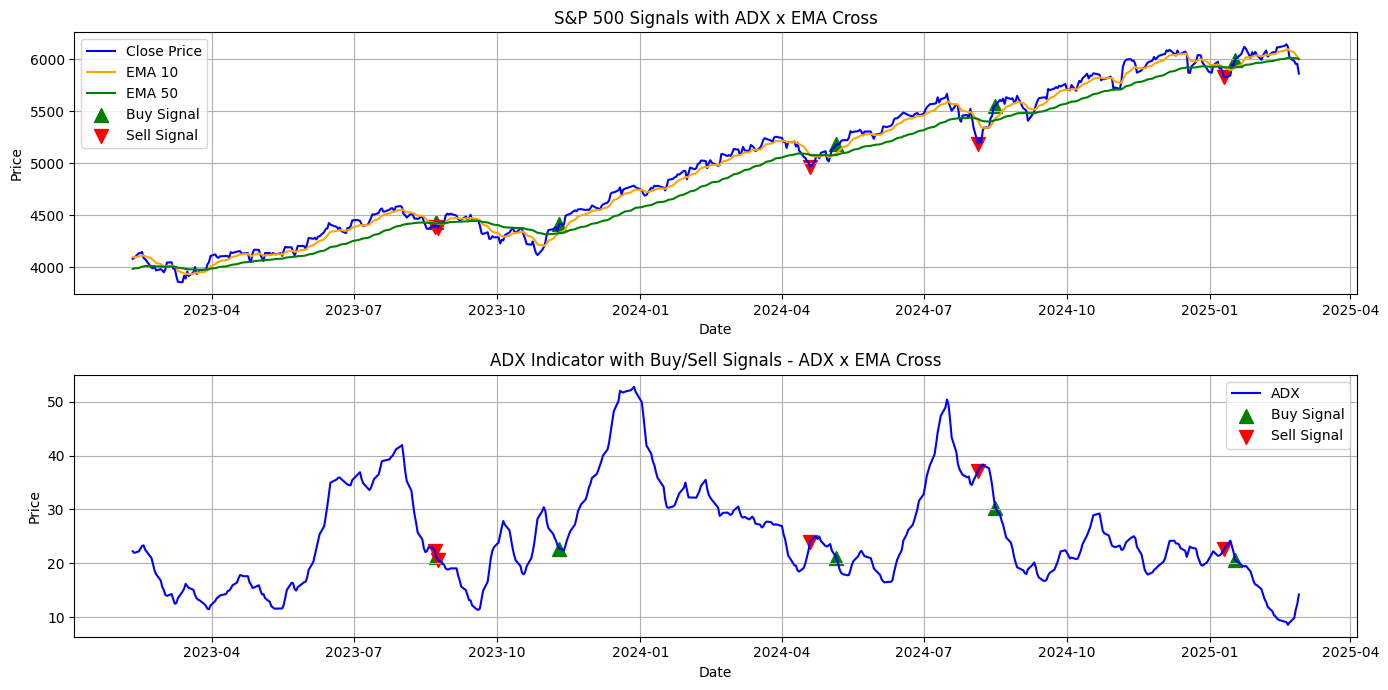

In [ ]:
train_size = int(0.8 * len(data_df))
test_size = len(data_df) - int(0.8 * len(data_df))
plot_df = data_df.tail(test_size)
fig, axs = plt.subplots(2, 1, figsize=(14, 7))

axs[0].plot(plot_df['Date'], plot_df['Close'], label='Close Price', color='blue')
axs[0].plot(plot_df['Date'], plot_df['EMA10'], label='EMA 10', color='orange')
axs[0].plot(plot_df['Date'], plot_df['EMA50'], label='EMA 50', color='green')
buy_signals = plot_df[plot_df['ADX_EMA_Cross'] == 1]
axs[0].scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', label='Buy Signal', s=100)
sell_signals = plot_df[plot_df['ADX_EMA_Cross'] == -1]
axs[0].scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', label='Sell Signal', s=100)

axs[0].set_title('S&P 500 Signals with ADX x EMA Cross')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
axs[0].legend()
axs[0].grid()

axs[1].plot(plot_df['Date'], plot_df['ADX'], label='ADX', color='blue')
axs[1].scatter(buy_signals['Date'], buy_signals['ADX'], marker='^', color='green', label='Buy Signal', s=100)
axs[1].scatter(sell_signals['Date'], sell_signals['ADX'], marker='v', color='red', label='Sell Signal', s=100)

axs[1].set_title('ADX Indicator with Buy/Sell Signals - ADX x EMA Cross')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price')
axs[1].legend()
axs[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

**Trade signals from ADX x RSI Cross**

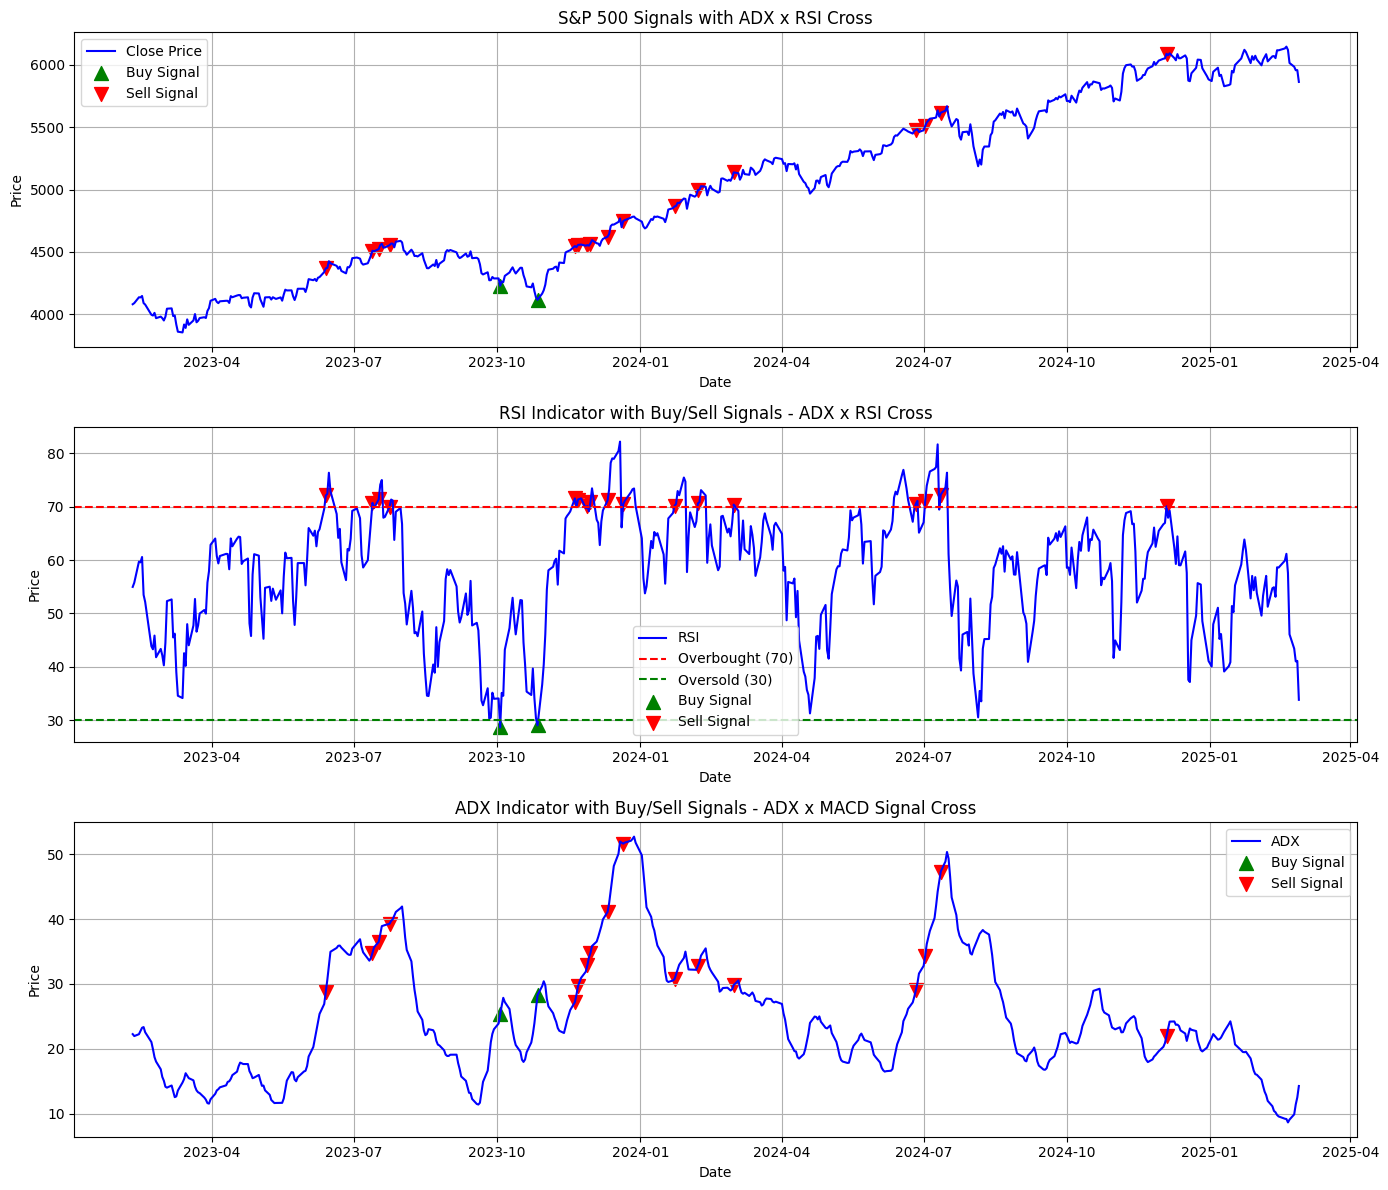

In [ ]:
train_size = int(0.8 * len(data_df))
test_size = len(data_df) - int(0.8 * len(data_df))
plot_df = data_df.tail(test_size)
fig, axs = plt.subplots(3, 1, figsize=(14, 12))

axs[0].plot(plot_df['Date'], plot_df['Close'], label='Close Price', color='blue')
buy_signals = plot_df[plot_df['ADX_RSI_Cross'] == 1]
axs[0].scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', label='Buy Signal', s=100)
sell_signals = plot_df[plot_df['ADX_RSI_Cross'] == -1]
axs[0].scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', label='Sell Signal', s=100)

axs[0].set_title('S&P 500 Signals with ADX x RSI Cross')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
axs[0].legend()
axs[0].grid()

axs[1].plot(plot_df['Date'], plot_df['RSI'], label='RSI', color='blue')
axs[1].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axs[1].axhline(30, color='green', linestyle='--', label='Oversold (30)')
axs[1].scatter(buy_signals['Date'], buy_signals['RSI'], marker='^', color='green', label='Buy Signal', s=100)
axs[1].scatter(sell_signals['Date'], sell_signals['RSI'], marker='v', color='red', label='Sell Signal', s=100)

axs[1].set_title('RSI Indicator with Buy/Sell Signals - ADX x RSI Cross')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price')
axs[1].legend()
axs[1].grid()

axs[2].plot(plot_df['Date'], plot_df['ADX'], label='ADX', color='blue')
axs[2].scatter(buy_signals['Date'], buy_signals['ADX'], marker='^', color='green', label='Buy Signal', s=100)
axs[2].scatter(sell_signals['Date'], sell_signals['ADX'], marker='v', color='red', label='Sell Signal', s=100)

axs[2].set_title('ADX Indicator with Buy/Sell Signals - ADX x MACD Signal Cross')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Price')
axs[2].legend()
axs[2].grid()

# Adjust layout
plt.tight_layout()
plt.show()

**Trade signals from ADX x RSI Cross back**

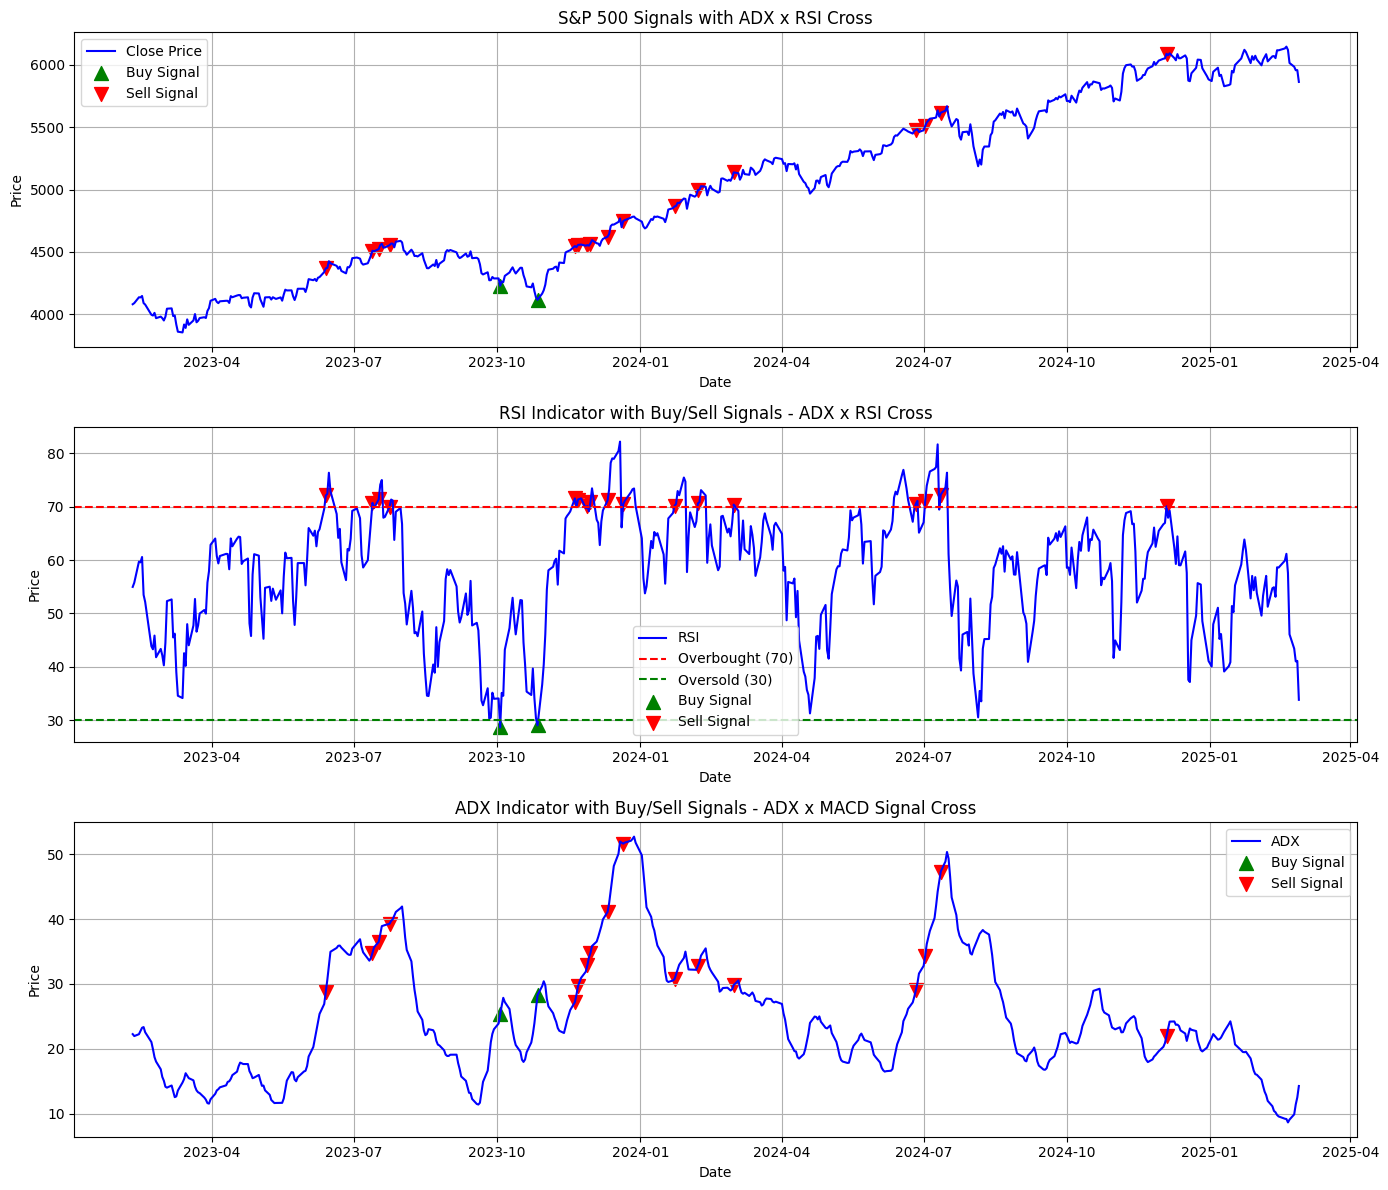

In [ ]:
train_size = int(0.8 * len(data_df))
test_size = len(data_df) - int(0.8 * len(data_df))
plot_df = data_df.tail(test_size)
fig, axs = plt.subplots(3, 1, figsize=(14, 12))

axs[0].plot(plot_df['Date'], plot_df['Close'], label='Close Price', color='blue')
buy_signals = plot_df[plot_df['ADX_RSI_Cross'] == 1]
axs[0].scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', label='Buy Signal', s=100)
sell_signals = plot_df[plot_df['ADX_RSI_Cross'] == -1]
axs[0].scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', label='Sell Signal', s=100)

axs[0].set_title('S&P 500 Signals with ADX x RSI Cross')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
axs[0].legend()
axs[0].grid()

axs[1].plot(plot_df['Date'], plot_df['RSI'], label='RSI', color='blue')
axs[1].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axs[1].axhline(30, color='green', linestyle='--', label='Oversold (30)')
axs[1].scatter(buy_signals['Date'], buy_signals['RSI'], marker='^', color='green', label='Buy Signal', s=100)
axs[1].scatter(sell_signals['Date'], sell_signals['RSI'], marker='v', color='red', label='Sell Signal', s=100)

axs[1].set_title('RSI Indicator with Buy/Sell Signals - ADX x RSI Cross')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price')
axs[1].legend()
axs[1].grid()

axs[2].plot(plot_df['Date'], plot_df['ADX'], label='ADX', color='blue')
axs[2].scatter(buy_signals['Date'], buy_signals['ADX'], marker='^', color='green', label='Buy Signal', s=100)
axs[2].scatter(sell_signals['Date'], sell_signals['ADX'], marker='v', color='red', label='Sell Signal', s=100)

axs[2].set_title('ADX Indicator with Buy/Sell Signals - ADX x MACD Signal Cross')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Price')
axs[2].legend()
axs[2].grid()

# Adjust layout
plt.tight_layout()
plt.show()

**Trade signals from ADX x MACD Signal Cross**

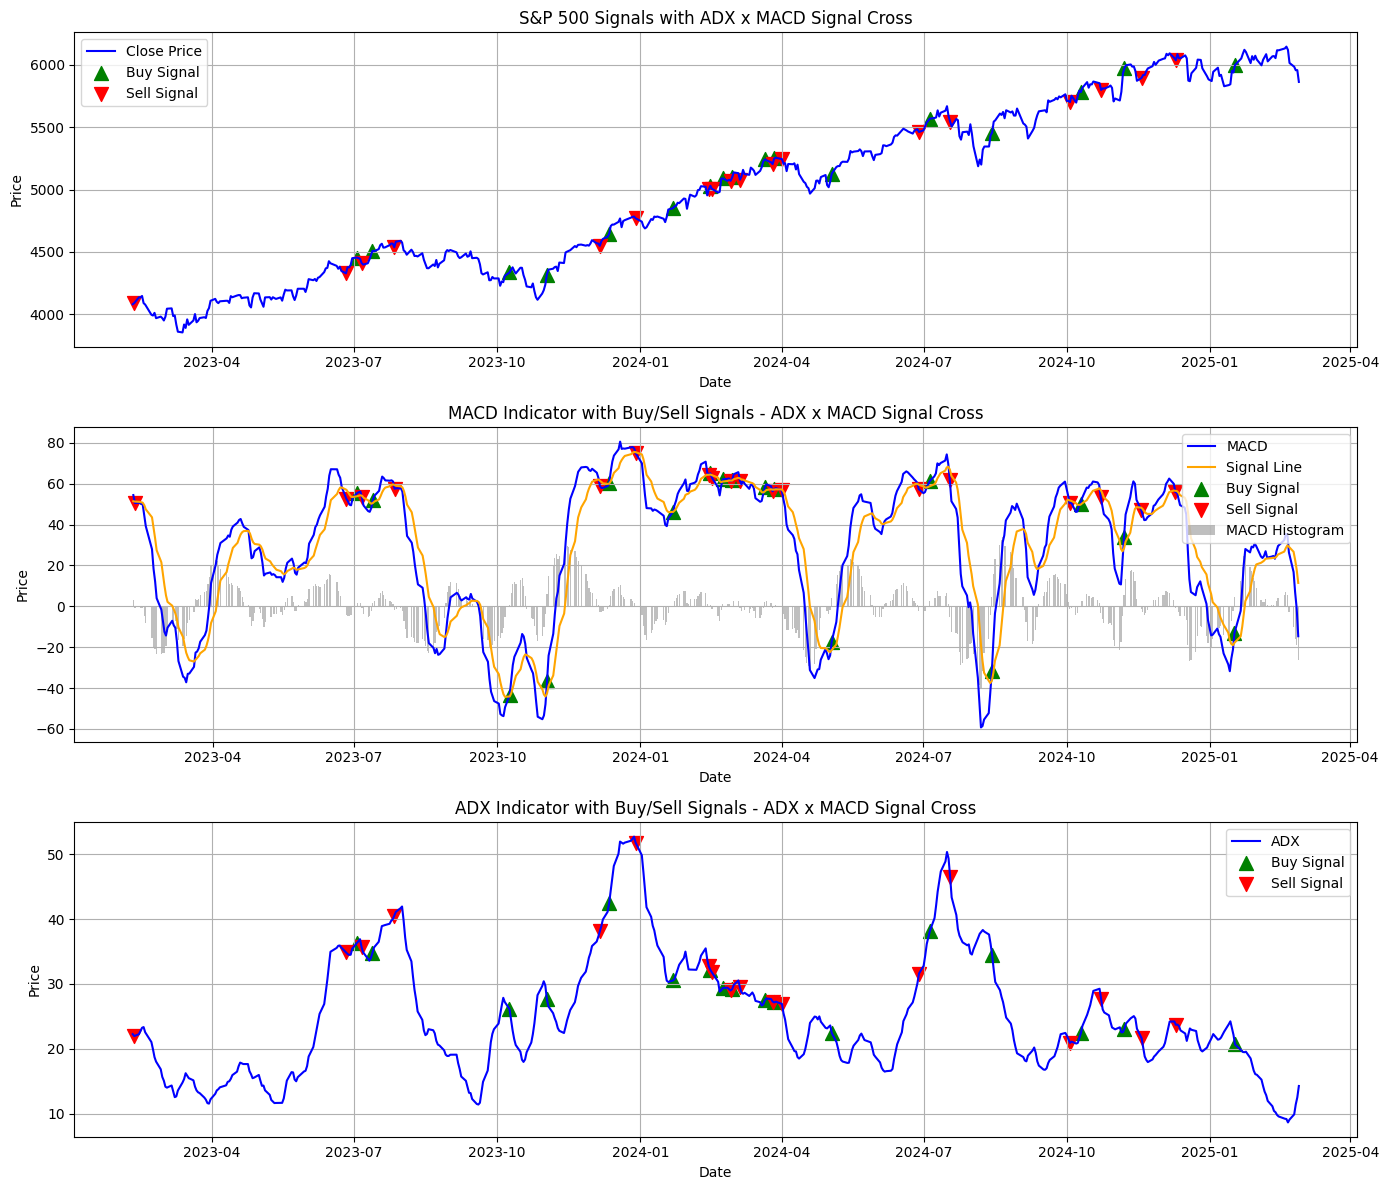

In [ ]:
train_size = int(0.8 * len(data_df))
test_size = len(data_df) - int(0.8 * len(data_df))
plot_df = data_df.tail(test_size)
fig, axs = plt.subplots(3, 1, figsize=(14, 12))

axs[0].plot(plot_df['Date'], plot_df['Close'], label='Close Price', color='blue')
buy_signals = plot_df[plot_df['ADX_MACD_Signal_Cross'] == 1]
axs[0].scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', label='Buy Signal', s=100)
sell_signals = plot_df[plot_df['ADX_MACD_Signal_Cross'] == -1]
axs[0].scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', label='Sell Signal', s=100)

axs[0].set_title('S&P 500 Signals with ADX x MACD Signal Cross')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
axs[0].legend()
axs[0].grid()

axs[1].plot(plot_df['Date'], plot_df['MACD'], label='MACD', color='blue')
axs[1].plot(plot_df['Date'], plot_df['MACD_Signal'], label='Signal Line', color='orange')
axs[1].bar(plot_df['Date'], plot_df['MACD_Hist'], label='MACD Histogram', color='grey', alpha=0.5)
axs[1].scatter(buy_signals['Date'], buy_signals['MACD'], marker='^', color='green', label='Buy Signal', s=100)
axs[1].scatter(sell_signals['Date'], sell_signals['MACD'], marker='v', color='red', label='Sell Signal', s=100)

axs[1].set_title('MACD Indicator with Buy/Sell Signals - ADX x MACD Signal Cross')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price')
axs[1].legend()
axs[1].grid()

axs[2].plot(plot_df['Date'], plot_df['ADX'], label='ADX', color='blue')
axs[2].scatter(buy_signals['Date'], buy_signals['ADX'], marker='^', color='green', label='Buy Signal', s=100)
axs[2].scatter(sell_signals['Date'], sell_signals['ADX'], marker='v', color='red', label='Sell Signal', s=100)

axs[2].set_title('ADX Indicator with Buy/Sell Signals - ADX x MACD Signal Cross')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Price')
axs[2].legend()
axs[2].grid()

# Adjust layout
plt.tight_layout()
plt.show()

**Trade signals from ADX x MACD Zero Cross**

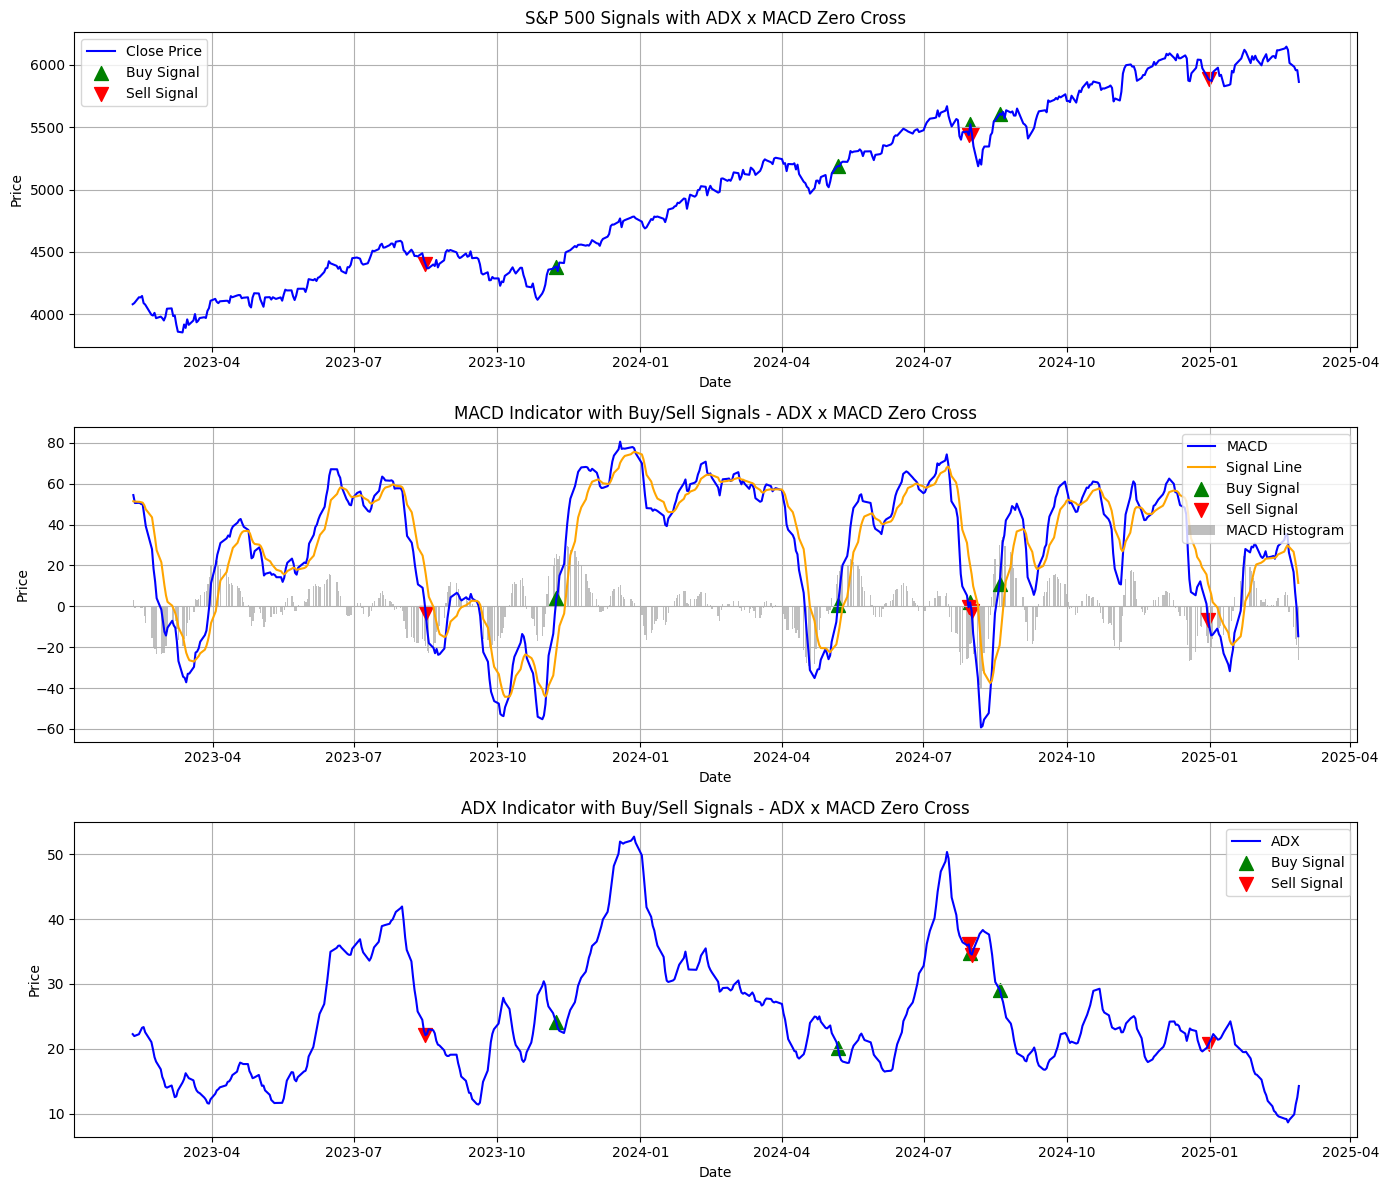

In [ ]:
train_size = int(0.8 * len(data_df))
test_size = len(data_df) - int(0.8 * len(data_df))
plot_df = data_df.tail(test_size)
fig, axs = plt.subplots(3, 1, figsize=(14, 12))

axs[0].plot(plot_df['Date'], plot_df['Close'], label='Close Price', color='blue')
buy_signals = plot_df[plot_df['ADX_MACD_Zero_Cross'] == 1]
axs[0].scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', label='Buy Signal', s=100)
sell_signals = plot_df[plot_df['ADX_MACD_Zero_Cross'] == -1]
axs[0].scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', label='Sell Signal', s=100)

axs[0].set_title('S&P 500 Signals with ADX x MACD Zero Cross')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
axs[0].legend()
axs[0].grid()

axs[1].plot(plot_df['Date'], plot_df['MACD'], label='MACD', color='blue')
axs[1].plot(plot_df['Date'], plot_df['MACD_Signal'], label='Signal Line', color='orange')
axs[1].bar(plot_df['Date'], plot_df['MACD_Hist'], label='MACD Histogram', color='grey', alpha=0.5)
axs[1].scatter(buy_signals['Date'], buy_signals['MACD'], marker='^', color='green', label='Buy Signal', s=100)
axs[1].scatter(sell_signals['Date'], sell_signals['MACD'], marker='v', color='red', label='Sell Signal', s=100)

axs[1].set_title('MACD Indicator with Buy/Sell Signals - ADX x MACD Zero Cross')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price')
axs[1].legend()
axs[1].grid()

axs[2].plot(plot_df['Date'], plot_df['ADX'], label='ADX', color='blue')
axs[2].scatter(buy_signals['Date'], buy_signals['ADX'], marker='^', color='green', label='Buy Signal', s=100)
axs[2].scatter(sell_signals['Date'], sell_signals['ADX'], marker='v', color='red', label='Sell Signal', s=100)

axs[2].set_title('ADX Indicator with Buy/Sell Signals - ADX x MACD Zero Cross')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Price')
axs[2].legend()
axs[2].grid()

# Adjust layout
plt.tight_layout()
plt.show()

ADX is a pure momentum indicator, which quantifies the strength of a trend, without showing its direction. ADX ranges from 0 to 100, and a common threshold for strong trend is when ADX is higher than 20. Given its nature with no directional indication, it is usually used together with other trend indicators, including SMA/EMA, RSI and MACD.

We observe that when combining ADX with SMA/EMA, RSI or MACD, it helps to remove some noise and achieve better results. Yet, it won’t be able to solve all the issues that we mentioned above.

**On-Balance Volume (OBV) and Accumulation/Distribution Line (A/D Line)**

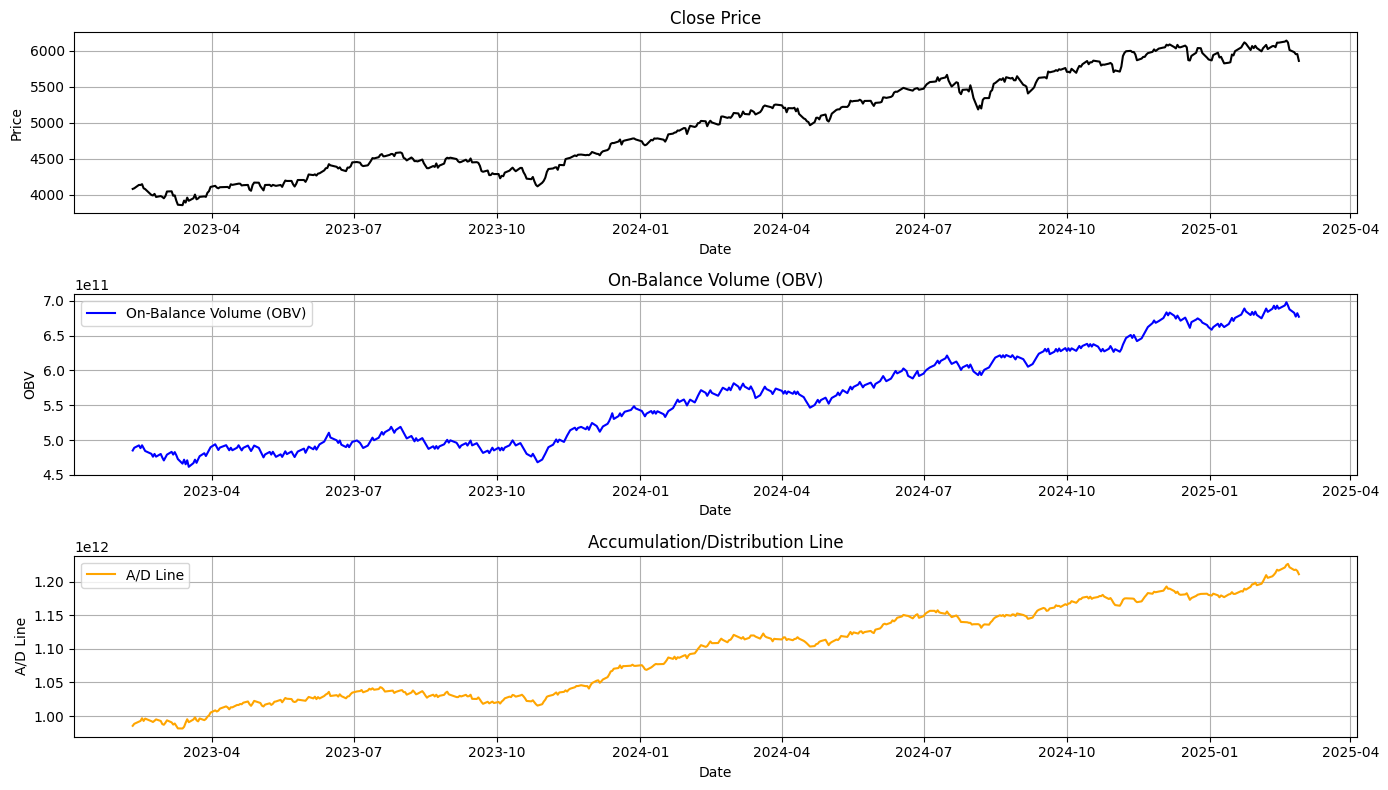

In [ ]:
train_size = int(0.8 * len(data_df))
test_size = len(data_df) - int(0.8 * len(data_df))
plot_df = data_df.tail(test_size)

plt.figure(figsize=(14, 8))

# Plot Close Price
plt.subplot(3, 1, 1)
plt.plot(plot_df['Date'], plot_df['Close'], label='Close Price', color='black')
plt.title('Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()

# Plot OBV
plt.subplot(3, 1, 2)
plt.plot(plot_df['Date'], plot_df['OBV'], label='On-Balance Volume (OBV)', color='blue')
#plt.bar(plot_df['Date'], plot_df['OBV_Slope'], label='On-Balance Volume (OBV)', color='grey', alpha=0.5)
plt.title('On-Balance Volume (OBV)')
plt.xlabel('Date')
plt.ylabel('OBV')
plt.legend()
plt.grid()

# Plot A/D Line
plt.subplot(3, 1, 3)
plt.plot(plot_df['Date'], plot_df['A/D Line'], label='A/D Line', color='orange')
plt.title('Accumulation/Distribution Line')
plt.xlabel('Date')
plt.ylabel('A/D Line')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


OBV and A/D Line are volume indicators. OBV measures the buying or selling pressure, by aggregating the volume according to stock price movement. On the other hand, A/D Line measures the cumulative in/out flow of money into the stock i.e. volume accumulation or distribution. Their actual value is not important, but rather the trend of these two metrics would suggest the trend of the stock price. When these metrics are increasing, this suggests a bullish trend, and vice versa. These volume metrics are usually used to confirm a trend or to alert for a potential reversal. They could supplement the momentum indicators that we introduced above.

In a high level view, we see the upward trend on OBV and A/D Line, which is matching with the overall trend of S&P 500 level.

**Bollinger Bands and Average True Range (ATR)**

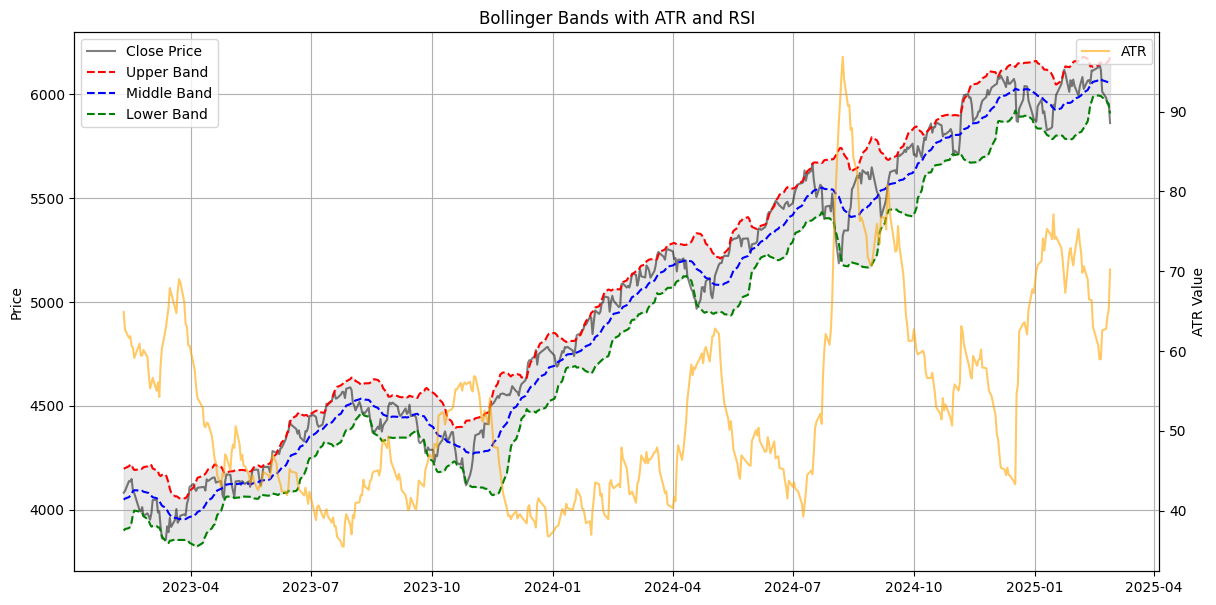

In [ ]:
train_size = int(0.8 * len(data_df))
test_size = len(data_df) - int(0.8 * len(data_df))
plot_df = data_df.tail(test_size)

fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotting Bollinger Bands
ax1.plot(plot_df['Date'], plot_df['Close'], label='Close Price', color='black', alpha=0.5)
ax1.plot(plot_df['Date'], plot_df['BB_Upper'], label='Upper Band', color='red', linestyle='--')
ax1.plot(plot_df['Date'], plot_df['BB_Middle'], label='Middle Band', color='blue', linestyle='--')
ax1.plot(plot_df['Date'], plot_df['BB_Lower'], label='Lower Band', color='green', linestyle='--')
ax1.fill_between(plot_df['Date'], plot_df['BB_Upper'], plot_df['BB_Lower'], color='lightgrey', alpha=0.5)
ax1.set_title('Bollinger Bands with ATR and RSI')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')
ax1.grid()

# Create a second y-axis for ATR
ax2 = ax1.twinx()
ax2.plot(plot_df['Date'], plot_df['ATR'], label='ATR', color='orange', alpha=0.6)
ax2.set_ylabel('ATR Value')
ax2.legend(loc='upper right')

'''
# Create a third y-axis for RSI
fig, ax3 = plt.subplots(figsize=(14, 3))
ax3.plot(plot_df['Date'], plot_df['RSI'], label='RSI', color='purple')
ax3.axhline(70, linestyle='--', color='red', alpha=0.5)
ax3.axhline(30, linestyle='--', color='green', alpha=0.5)
ax3.set_title('RSI')
ax3.set_ylabel('RSI Value')
ax3.grid()
'''

plt.show()

Bollinger Bands and Average True Range (ATR) are volatility indicator. Bollinger Bands show a 2x standard deviation range around both sides of the 20-day SMA. They could be viewed as a resistant level to indicate overbought/oversold. The range between upper and lower could serve as a measure of volatility. For ATR, it gives the max gap between current high/low and previous close price. It measures the volatility of the stock, in which a rising ATR indicates increasing volatility.

**Correlation**

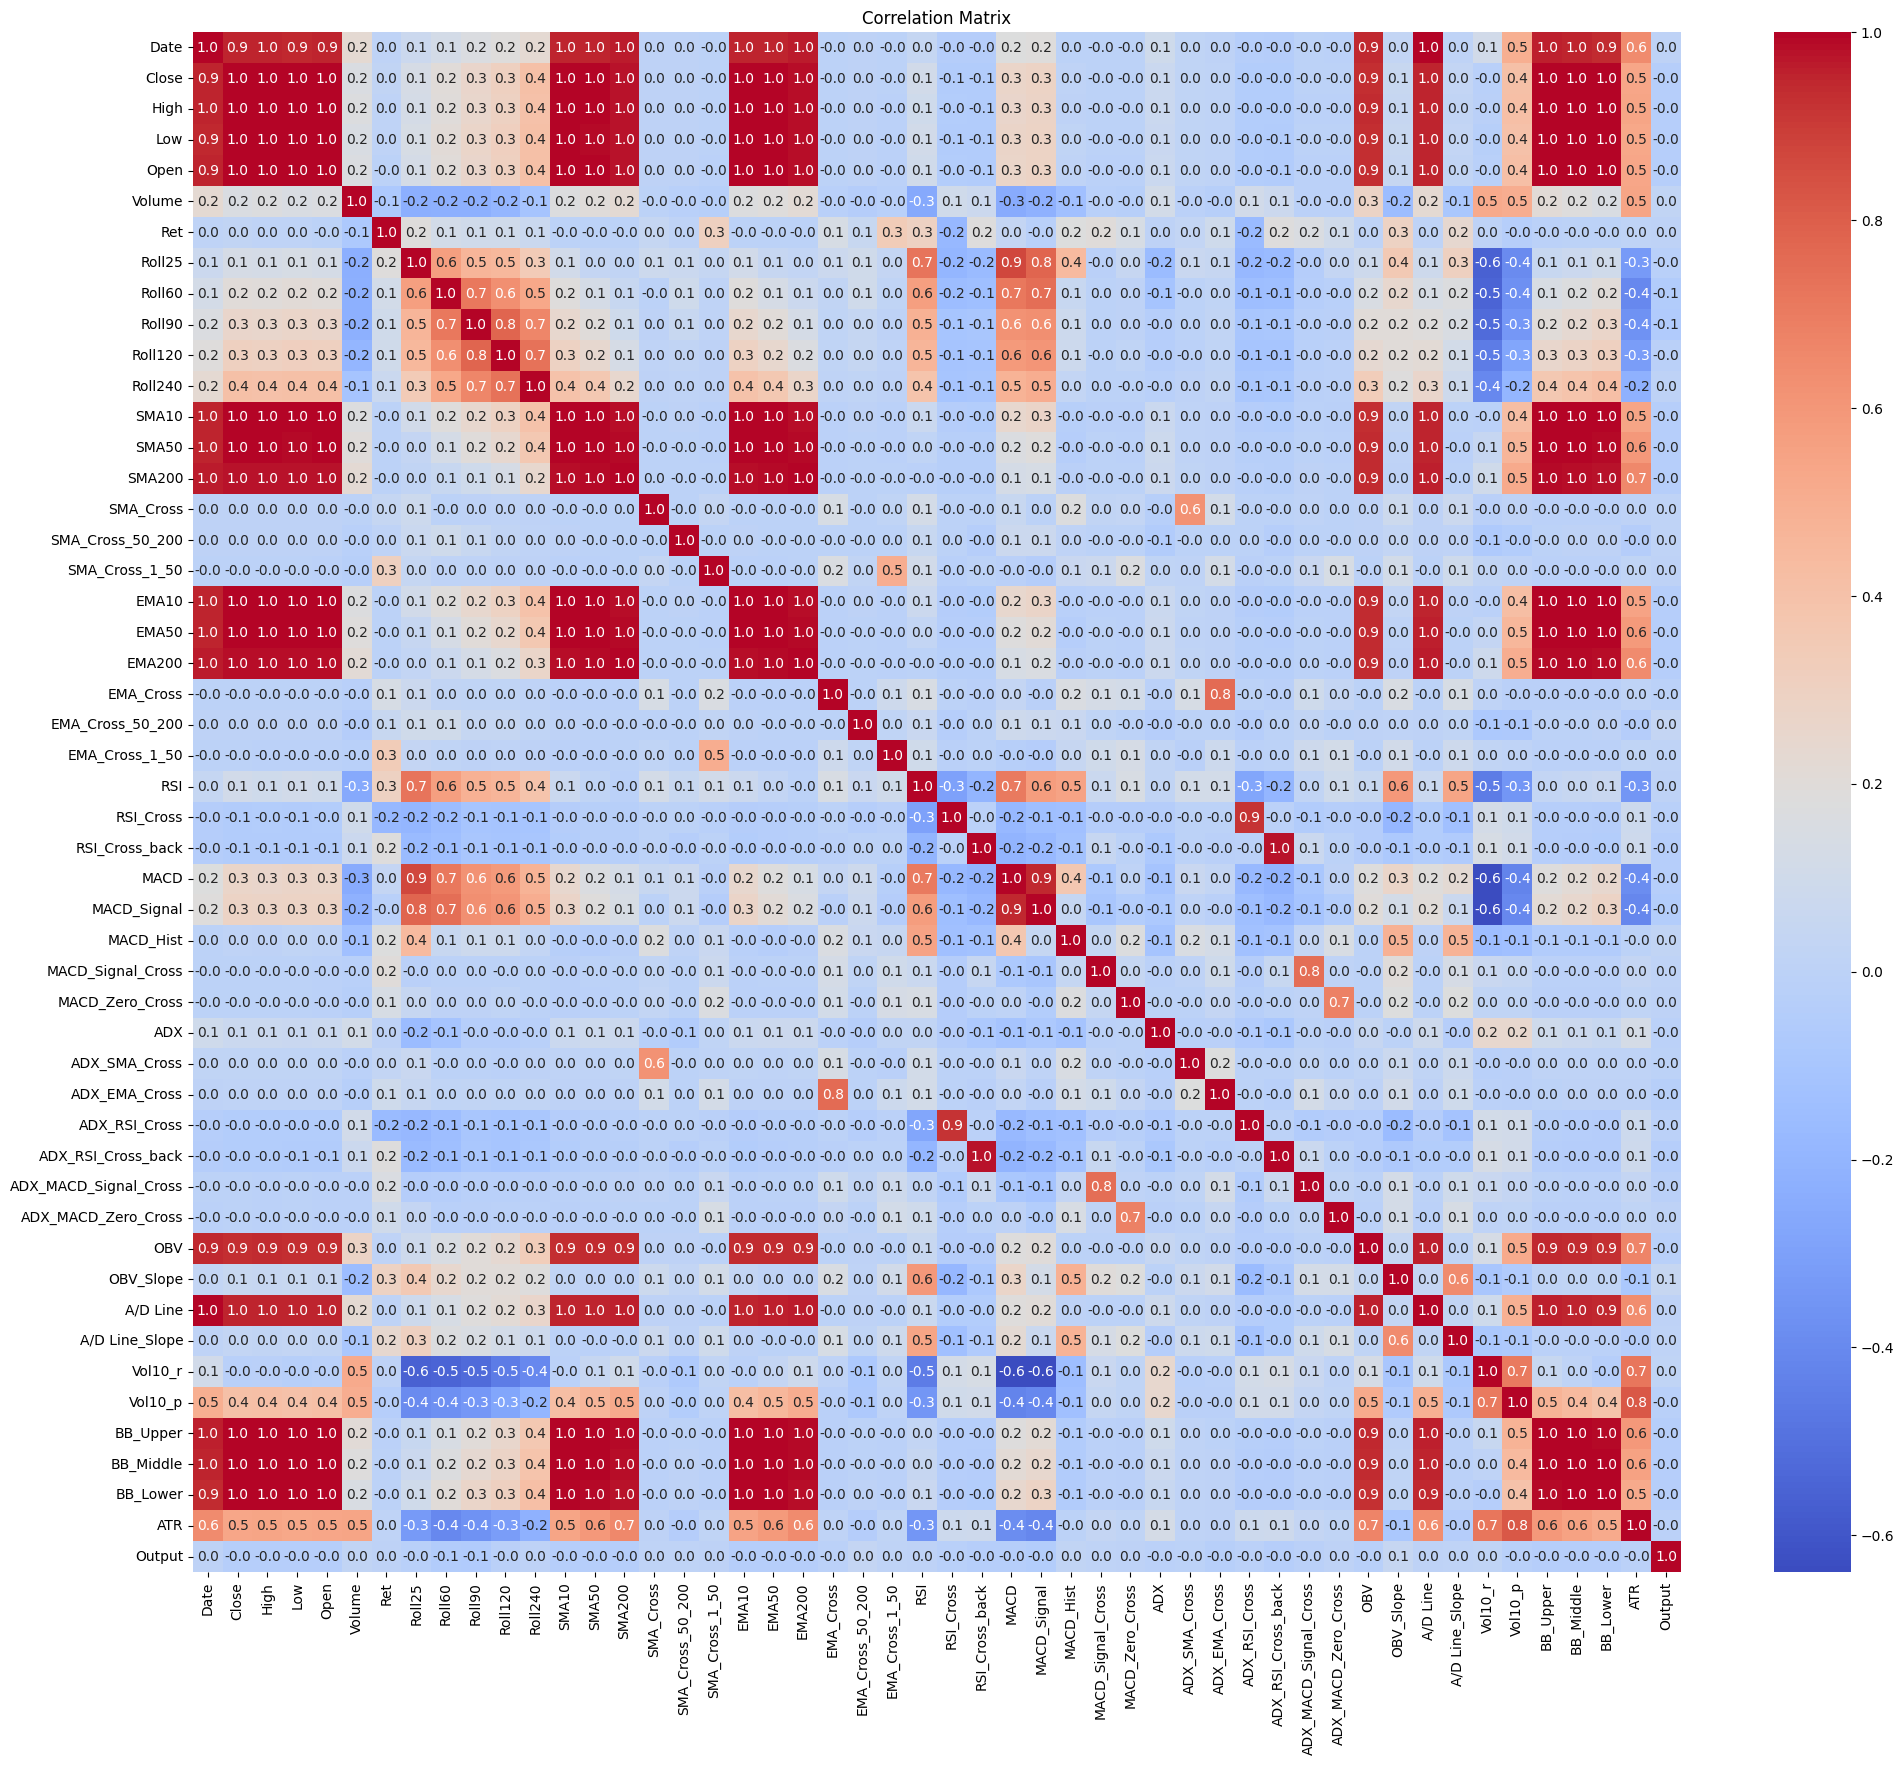

In [ ]:
plt.figure(figsize=(24, 20))
correlation_matrix = data_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

We see high correlation between OHLC price, SMA/EMA, OBV, A/D Line, Bollinger Bands. This makes sense as after all the stock price is a direct input in their computation. One point to note is the independence amongst signal generated by different momentum indicators. This suggests combining the information from these indicators could potentially have some benefit.

**Signals performance**

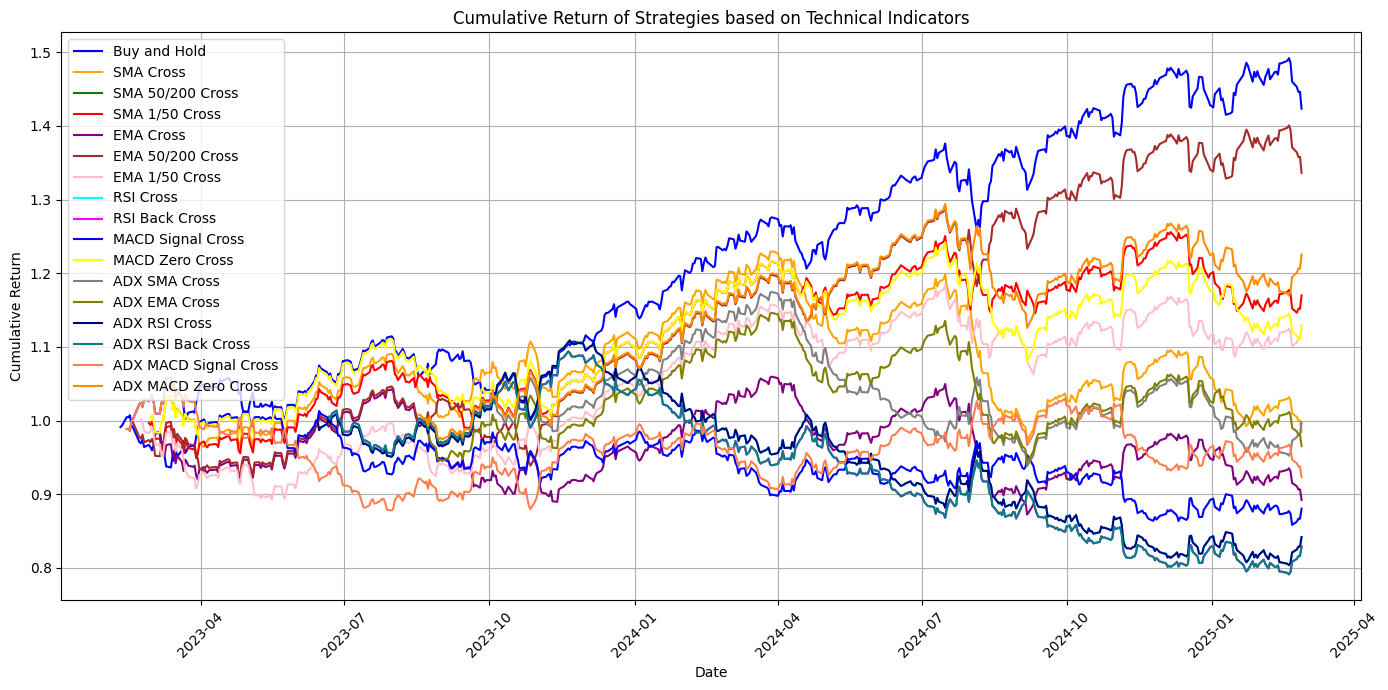

Final Cumulative Returns:
Buy and Hold: 1.42
SMA Cross: 0.98
SMA 50/200 Cross: nan
SMA 1/50 Cross: 1.17
EMA Cross: 0.89
EMA 50/200 Cross: 1.34
EMA 1/50 Cross: 1.13
RSI Cross: 0.84
RSI Back Cross: 0.83
MACD Signal Cross: 0.88
MACD Zero Cross: 1.13
ADX SMA Cross: 1.00
ADX EMA Cross: 0.97
ADX RSI Cross: 0.84
ADX RSI Back Cross: 0.83
ADX MACD Signal Cross: 0.92
ADX MACD Zero Cross: 1.23


In [ ]:
def plot_strategy(data, strategy_col, label, color):
    """
    Calculate and plot cumulative returns for a specified trading strategy.

    Parameters:
    - data: DataFrame containing the trading data.
    - strategy_col: Column name that indicates the trading signals (1 for buy, -1 for sell).
    - label: The label for the strategy in the plot.
    - color: The color for the plot line.

    Returns:
    - final_cumulative: The final cumulative return for the strategy.
    """
    # Create a temporary DataFrame to avoid modifying the original
    temp_df = data.copy()

    # Initialize Position column
    temp_df['Position'] = 0
    temp_df.loc[temp_df[strategy_col] == 1, 'Position'] = 1  # Buy signal
    temp_df.loc[temp_df[strategy_col] == -1, 'Position'] = -1  # Sell signal

    # Forward fill the Position to maintain active positions
    temp_df['Position'] = temp_df['Position'].replace(0, np.nan).ffill()

    # Calculate strategy returns
    temp_df['Strategy_Ret'] = temp_df['Ret'] * temp_df['Position'].shift(1)
    temp_df.loc[:, 'Cumulative_Ret'] = (1 + temp_df['Strategy_Ret']).cumprod()

    # Plot the cumulative return for this strategy
    plt.plot(temp_df['Date'], temp_df['Cumulative_Ret'], label=label, color=color)

    # Return the final cumulative return
    final_cumulative = temp_df['Cumulative_Ret'].iloc[-1]
    return final_cumulative

# Assuming data_df is already defined
train_size = int(0.8 * len(data_df))
test_size = len(data_df) - train_size
plot_df = data_df.tail(test_size).copy()
plot_df.loc[:, 'BH_Ret'] = (1 + plot_df.loc[:, 'Ret']).cumprod()

# List of strategies to plot
strategies = [
    ('SMA_Cross', 'SMA Cross', 'orange'),
    ('SMA_Cross_50_200', 'SMA 50/200 Cross', 'green'),
    ('SMA_Cross_1_50', 'SMA 1/50 Cross', 'red'),
    ('EMA_Cross', 'EMA Cross', 'purple'),
    ('EMA_Cross_50_200', 'EMA 50/200 Cross', 'brown'),
    ('EMA_Cross_1_50', 'EMA 1/50 Cross', 'pink'),
    ('RSI_Cross', 'RSI Cross', 'cyan'),
    ('RSI_Cross_back', 'RSI Back Cross', 'magenta'),
    ('MACD_Signal_Cross', 'MACD Signal Cross', 'blue'),
    ('MACD_Zero_Cross', 'MACD Zero Cross', 'yellow'),
    ('ADX_SMA_Cross', 'ADX SMA Cross', 'grey'),
    ('ADX_EMA_Cross', 'ADX EMA Cross', 'olive'),
    ('ADX_RSI_Cross', 'ADX RSI Cross', 'navy'),
    ('ADX_RSI_Cross_back', 'ADX RSI Back Cross', 'teal'),
    ('ADX_MACD_Signal_Cross', 'ADX MACD Signal Cross', 'coral'),
    ('ADX_MACD_Zero_Cross', 'ADX MACD Zero Cross', 'darkorange')
]

# Plotting Buy and Hold strategy
plt.figure(figsize=(14, 7))
plt.plot(plot_df['Date'], plot_df['BH_Ret'], label='Buy and Hold', color='blue')

# Loop through each strategy and plot
final_cumulative_returns = {'Buy and Hold': plot_df['BH_Ret'].iloc[-1]}
for strategy_col, label, color in strategies:
    final_cumulative = plot_strategy(plot_df, strategy_col, label, color)
    final_cumulative_returns[label] = final_cumulative

# Final plot adjustments
plt.title('Cumulative Return of Strategies based on Technical Indicators')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Print final cumulative returns
print("Final Cumulative Returns:")
for strategy, cumulative_return in final_cumulative_returns.items():
    print(f"{strategy}: {cumulative_return:.2f}")